In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from catboost import CatBoostRegressor

# Load the CSV
cluster0_df = pd.read_csv('/content/drive/My Drive/forecasting/cluster_0.csv')

In [2]:
cluster0_df

Invoice StockCode                          Description  Quantity  \
0      489436     84879        ASSORTED COLOUR BIRD ORNAMENT        16   
1      489436    84596F         SMALL MARSHMALLOWS PINK BOWL         8   
2      489437     20971     PINK BLUE FELT CRAFT TRINKET BOX        12   
3      489437     22274                 FELTCRAFT DOLL EMILY         6   
4      489438     21411          GINGHAM HEART  DOORSTOP RED        32   
...       ...       ...                                  ...       ...   
80884  581580    85049E            SCANDINAVIAN REDS RIBBONS         2   
80885  581585     84879        ASSORTED COLOUR BIRD ORNAMENT        16   
80886  581585     21916      SET 12 RETRO WHITE CHALK STICKS        24   
80887  581585     84692          BOX OF 24 COCKTAIL PARASOLS        25   
80888  581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   

               InvoiceDate  Price  Customer ID         Country YearMonth  \
0      2009-12-01 09:06:00   1.69      13078.0  United Kingdom   2009-12   
1      2009-12-01 09:06:00   1.25      13078.0  United Kingdom   2009-12   
2      2009-12-01 09:08:00   1.25      15362.0  United Kingdom   2009-12   
3      2009-12-01 09:08:00   2.95      15362.0  United Kingdom   2009-12   
4      2009-12-01 09:24:00   2.50      18102.0  United Kingdom   2009-12   
...                    ...    ...          ...             ...       ...   
80884  2011-12-09 12:20:00   1.25      12748.0  United Kingdom   2011-12   
80885  2011-12-09 12:31:00   1.69      15804.0  United Kingdom   2011-12   
80886  2011-12-09 12:31:00   0.42      15804.0  United Kingdom   2011-12   
80887  2011-12-09 12:31:00   0.42      15804.0  United Kingdom   2011-12   
80888  2011-12-09 12:49:00   2.95      13113.0  United Kingdom   2011-12   

      SP500_Close   CPI  data_based_cluster  desc_based_cluster  \
0        1,115.10  2.51                   6                   1   
1        1,115.10  2.51                   3                   2   
2        1,115.10  2.51                   5                   6   
3        1,115.10  2.51                   7                   4   
4        1,115.10  2.51                   4                   7   
...           ...   ...                 ...                 ...   
80884    1,257.60  3.69                   6                   4   
80885    1,257.60  3.69                   6                   1   
80886    1,257.60  3.69                   7                   4   
80887    1,257.60  3.69                   8                   5   
80888    1,257.60  3.69                   4                   2   

       word2vec_cluster  SalesValue  
0                     0       27.04  
1                     0       10.00  
2                     0       15.00  
3                     0       17.70  
4                     0       80.00  
...                 ...         ...  
80884                 0        2.50  
80885                 0       27.04  
80886                 0       10.08  
80887                 0       10.50  
80888                 0       23.60  

[80889 rows x 15 columns]

In [3]:
# 1. Ensure datetime format
cluster0_df['InvoiceDate'] = pd.to_datetime(cluster0_df['InvoiceDate'])

# 2. Resample to daily sales
daily_sales = (
    cluster0_df
    .set_index('InvoiceDate')
    .resample('D')['SalesValue']
    .sum()
    .reset_index()
    .rename(columns={'InvoiceDate': 'ds', 'SalesValue': 'y'})
    .sort_values('ds')
)

# 3. Fill missing dates (optional)
daily_sales['y'] = daily_sales['y'].fillna(0)

# Preview
daily_sales


ds         y
0   2009-12-01   5429.74
1   2009-12-02   7410.48
2   2009-12-03  11362.15
3   2009-12-04   3767.22
4   2009-12-05   1383.51
..         ...       ...
734 2011-12-05   4051.85
735 2011-12-06   2568.05
736 2011-12-07   2119.65
737 2011-12-08   2887.02
738 2011-12-09   1705.32

[739 rows x 2 columns]

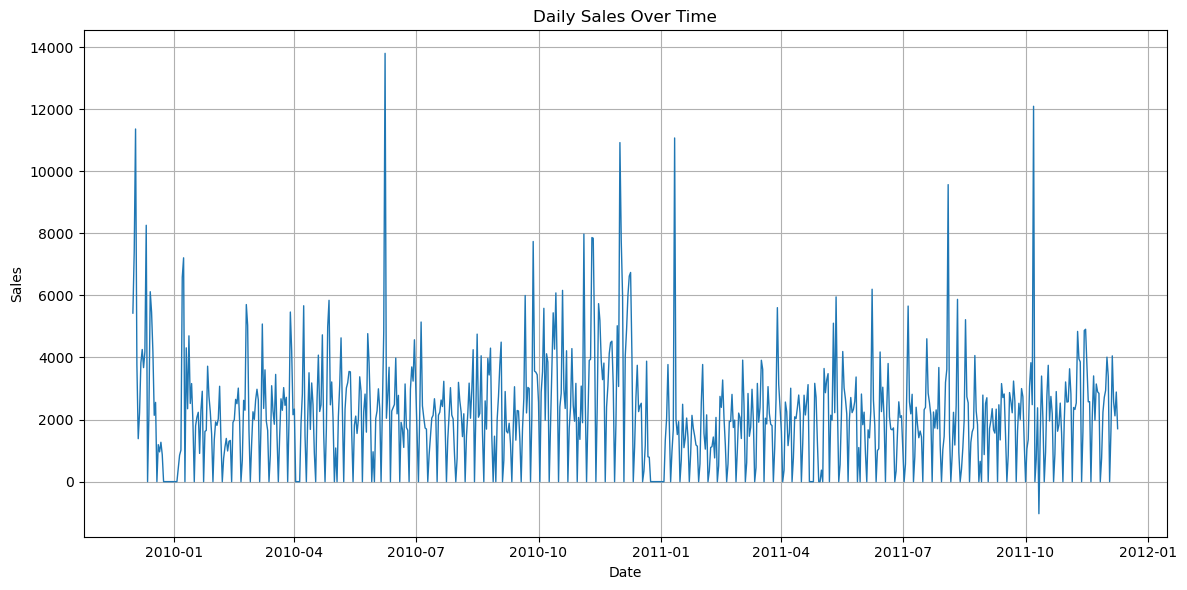

In [4]:
# Ensure ds is datetime
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['ds'], daily_sales['y'], linewidth=1)
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Ensure InvoiceDate is datetime
cluster0_df['InvoiceDate'] = pd.to_datetime(cluster0_df['InvoiceDate'])

# Set date as index
cluster0_df.set_index('InvoiceDate', inplace=True)

# Weekly sum of SalesValue only
weekly_sales = cluster0_df['SalesValue'].resample('W').sum().reset_index()

# Display the result
print(weekly_sales.head())


  InvoiceDate  SalesValue
0  2009-12-06    31579.79
1  2009-12-13    26370.31
2  2009-12-20    21643.01
3  2009-12-27     3094.75
4  2010-01-03        0.00


In [6]:
weekly_sales[weekly_sales['SalesValue'] == 0]

InvoiceDate  SalesValue
4   2010-01-03         0.0
56  2011-01-02         0.0

In [7]:
# Step 1: Prepare data
weekly_sales['InvoiceDate'] = pd.to_datetime(weekly_sales['InvoiceDate'])
weekly_sales = weekly_sales.sort_values('InvoiceDate').reset_index(drop=True)

# Step 2: Define holiday checker
def is_holiday_week(date):
    md = date.strftime('%m-%d')
    return ('12-24' <= md <= '12-31') or ('01-01' <= md <= '01-06')

# Step 3: Sliding window construction
window_size = 8
X = []
y = []
months = []
holidays = []

for i in range(len(weekly_sales) - window_size):
    window = weekly_sales['SalesValue'].iloc[i:i+window_size].values
    target = weekly_sales['SalesValue'].iloc[i + window_size]
    target_date = weekly_sales['InvoiceDate'].iloc[i + window_size]

    X.append(window)
    y.append(target)
    months.append(target_date.month)
    holidays.append(1 if is_holiday_week(target_date) else 0)

# Step 4: Combine into DataFrame
X = np.array(X)
df_windowed = pd.DataFrame(X, columns=[f'week_{i}' for i in range(window_size)])
df_windowed['target'] = y
df_windowed['month'] = months
df_windowed['holiday'] = holidays

# Step 5: One-hot encode the month
df_windowed = pd.get_dummies(df_windowed, columns=['month'], prefix='month')

# Preview
print(df_windowed.head())


     week_0    week_1    week_2    week_3    week_4    week_5    week_6  \
0  31579.79  26370.31  21643.01   3094.75      0.00  20411.84  16434.66   
1  26370.31  21643.01   3094.75      0.00  20411.84  16434.66  12048.40   
2  21643.01   3094.75      0.00  20411.84  16434.66  12048.40  13265.47   
3   3094.75      0.00  20411.84  16434.66  12048.40  13265.47  10926.08   
4      0.00  20411.84  16434.66  12048.40  13265.47  10926.08   8026.73   

     week_7    target  holiday  ...  month_3  month_4  month_5  month_6  \
0  12048.40  13265.47        0  ...    False    False    False    False   
1  13265.47  10926.08        0  ...    False    False    False    False   
2  10926.08   8026.73        0  ...    False    False    False    False   
3   8026.73  12793.50        0  ...    False    False    False    False   
4  12793.50  18539.73        0  ...    False    False    False    False   

   month_7  month_8  month_9  month_10  month_11  month_12  
0    False    False    False     Fals

In [8]:
df_windowed

week_0    week_1    week_2    week_3    week_4    week_5    week_6  \
0   31579.79  26370.31  21643.01   3094.75      0.00  20411.84  16434.66   
1   26370.31  21643.01   3094.75      0.00  20411.84  16434.66  12048.40   
2   21643.01   3094.75      0.00  20411.84  16434.66  12048.40  13265.47   
3    3094.75      0.00  20411.84  16434.66  12048.40  13265.47  10926.08   
4       0.00  20411.84  16434.66  12048.40  13265.47  10926.08   8026.73   
..       ...       ...       ...       ...       ...       ...       ...   
93  12375.67  15145.70  12576.21  23546.05   9244.47  14299.59  12402.83   
94  15145.70  12576.21  23546.05   9244.47  14299.59  12402.83  17196.84   
95  12576.21  23546.05   9244.47  14299.59  12402.83  17196.84  19119.08   
96  23546.05   9244.47  14299.59  12402.83  17196.84  19119.08  20706.48   
97   9244.47  14299.59  12402.83  17196.84  19119.08  20706.48  15021.31   

      week_7    target  holiday  ...  month_3  month_4  month_5  month_6  \
0   12048.40  13265.47        0  ...    False    False    False    False   
1   13265.47  10926.08        0  ...    False    False    False    False   
2   10926.08   8026.73        0  ...    False    False    False    False   
3    8026.73  12793.50        0  ...    False    False    False    False   
4   12793.50  18539.73        0  ...    False    False    False    False   
..       ...       ...      ...  ...      ...      ...      ...      ...   
93  17196.84  19119.08        0  ...    False    False    False    False   
94  19119.08  20706.48        0  ...    False    False    False    False   
95  20706.48  15021.31        0  ...    False    False    False    False   
96  15021.31  16914.08        0  ...    False    False    False    False   
97  16914.08  13331.89        0  ...    False    False    False    False   

    month_7  month_8  month_9  month_10  month_11  month_12  
0     False    False    False     False     False     False  
1     False    False    False     False     False     False  
2     False    False    False     False     False     False  
3     False    False    False     False     False     False  
4     False    False    False     False     False     False  
..      ...      ...      ...       ...       ...       ...  
93    False    False    False     False      True     False  
94    False    False    False     False      True     False  
95    False    False    False     False      True     False  
96    False    False    False     False     False      True  
97    False    False    False     False     False      True  

[98 rows x 22 columns]

In [9]:
# Determine split index (e.g., 80% train, 20% test)
split_index = int(len(df_windowed) * 0.8)

# Split
train_df = df_windowed.iloc[:split_index].reset_index(drop=True)
test_df = df_windowed.iloc[split_index:].reset_index(drop=True)

# Check result
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (78, 22)
Test shape: (20, 22)


In [10]:
# Step 1: Split features and target
X_train = train_df.drop(columns='target')
y_train = train_df['target']

X_test = test_df.drop(columns='target')
y_test = test_df['target']

# Step 2: Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict
y_pred = model.predict(X_test)

In [11]:
# Step 1: Split features and target
X_train = train_df.drop(columns='target')
y_train = train_df['target']
X_test = test_df.drop(columns='target')
y_test = test_df['target']

# Step 2: Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Step 3: Set up grid search
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 4: Best model
best_rf = grid_search.best_estimator_

# Step 5: Predict on test set
y_pred = best_rf.predict(X_test)


mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAPE: {mape:.2f}%")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [ ]:
# Avoid division by zero
nonzero_mask = y_test != 0
mape = np.mean(np.abs((y_test[nonzero_mask] - y_pred[nonzero_mask]) / y_test[nonzero_mask])) * 100

print(f"MAPE: {mape:.2f}%")


In [12]:
cluster1_df = pd.read_csv('/content/drive/My Drive/forecasting/cluster_1.csv')

cluster2_df = pd.read_csv('/content/drive/My Drive/forecasting/cluster_2.csv')


📊 Cluster 1 - Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
📉 Cluster 1 - MAPE: 18.70%


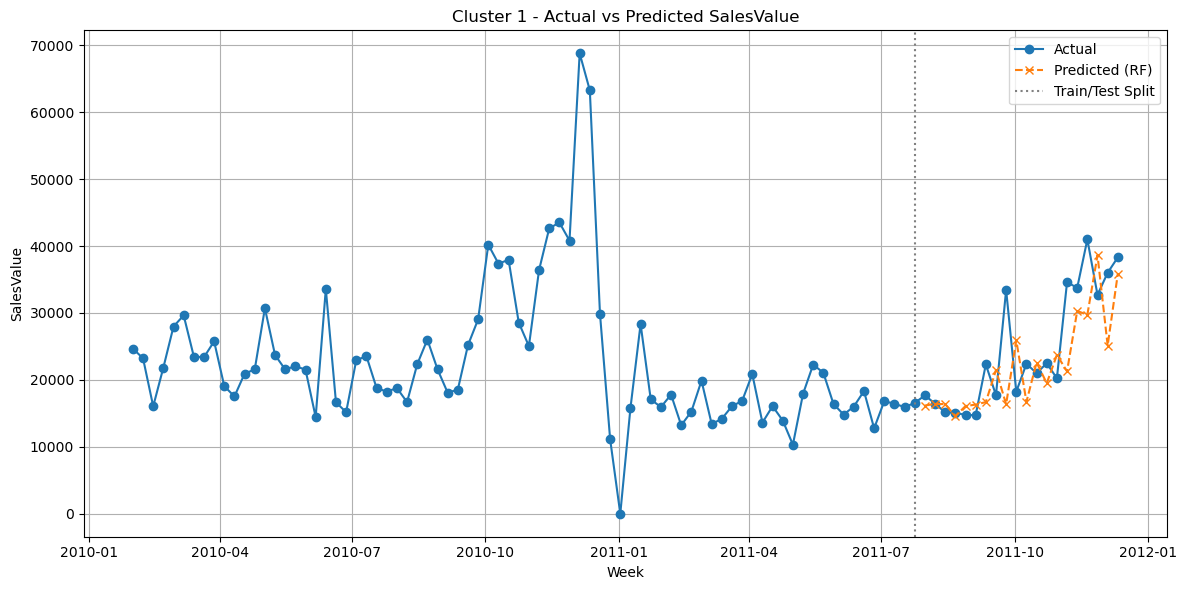

KeyboardInterrupt: 

In [13]:
def is_holiday_week(date):
    md = date.strftime('%m-%d')
    return ('12-24' <= md <= '12-31') or ('01-01' <= md <= '01-06')

def prepare_and_evaluate(cluster_df, cluster_name='cluster'):
    # Step 1: Weekly Sales Aggregation
    cluster_df['InvoiceDate'] = pd.to_datetime(cluster_df['InvoiceDate'])
    cluster_df.set_index('InvoiceDate', inplace=True)
    weekly_sales = cluster_df['SalesValue'].resample('W').sum().reset_index()

    # Step 2: Sliding Window with month and holiday
    window_size = 8
    X, y, months, holidays = [], [], [], []

    for i in range(len(weekly_sales) - window_size):
        window = weekly_sales['SalesValue'].iloc[i:i+window_size].values
        target = weekly_sales['SalesValue'].iloc[i + window_size]
        target_date = weekly_sales['InvoiceDate'].iloc[i + window_size]

        X.append(window)
        y.append(target)
        months.append(target_date.month)
        holidays.append(1 if is_holiday_week(target_date) else 0)

    df = pd.DataFrame(X, columns=[f'week_{j}' for j in range(window_size)])
    df['target'] = y
    df['month'] = months
    df['holiday'] = holidays
    df = pd.get_dummies(df, columns=['month'], prefix='month')

    # Step 3: Train-test split
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    test_df = df.iloc[split_idx:].reset_index(drop=True)

    X_train = train_df.drop(columns='target')
    y_train = train_df['target']
    X_test = test_df.drop(columns='target')
    y_test = test_df['target']

    # Step 4: Grid Search for Random Forest
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 5: Prediction and MAPE
    y_pred = best_model.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"\n📊 {cluster_name} - Best Parameters: {grid_search.best_params_}")
    print(f"📉 {cluster_name} - MAPE: {mape:.2f}%")

    # Step 6: Plot Actual vs Predicted
    # Step 6: Plot Actual vs Predicted with date as x-axis
    full_actual = pd.concat([train_df['target'], test_df['target']], ignore_index=True)
    full_pred = np.concatenate([np.full(len(train_df), np.nan), y_pred])

    # Get aligned dates from the weekly_sales DataFrame (after sliding window offset)
    weekly_sales = cluster_df['SalesValue'].resample('W').sum().reset_index()
    aligned_dates = weekly_sales['InvoiceDate'].iloc[window_size:].reset_index(drop=True)

    plt.figure(figsize=(12, 6))
    plt.plot(aligned_dates, full_actual, label='Actual', marker='o')
    plt.plot(aligned_dates, full_pred, label='Predicted (RF)', marker='x', linestyle='--')
    plt.axvline(aligned_dates.iloc[len(train_df)-1], color='gray', linestyle=':', label='Train/Test Split')

    plt.title(f'{cluster_name} - Actual vs Predicted SalesValue')
    plt.xlabel('Week')
    plt.ylabel('SalesValue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks()
    plt.show()


# Run this for your two clusters:
prepare_and_evaluate(cluster1_df, 'Cluster 1')
prepare_and_evaluate(cluster2_df, 'Cluster 2')



📊 Cluster 0 - Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
📉 Cluster 0 - MAPE: 23.37%


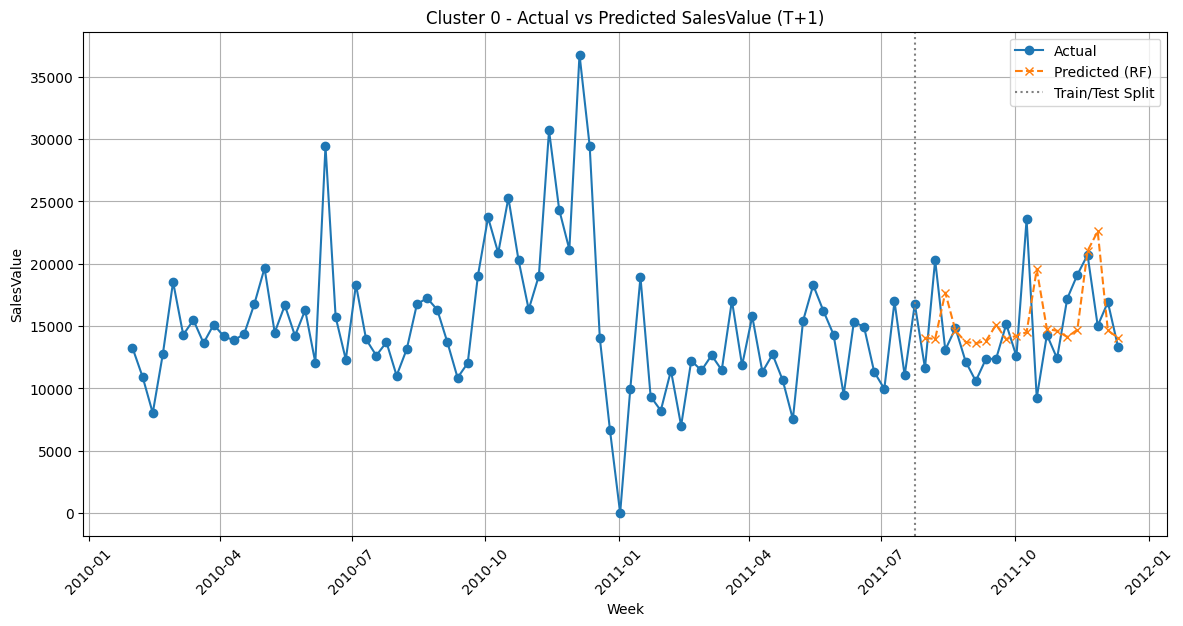


📊 Cluster 1 - Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
📉 Cluster 1 - MAPE: 18.70%


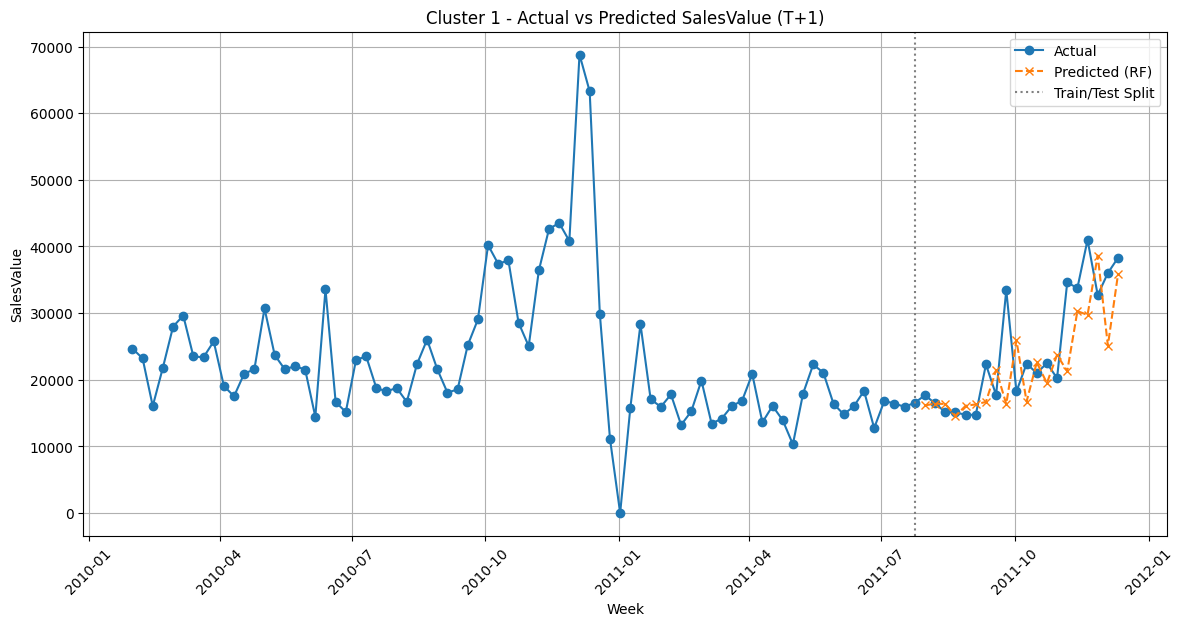


📊 Cluster 2 - Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
📉 Cluster 2 - MAPE: 15.79%


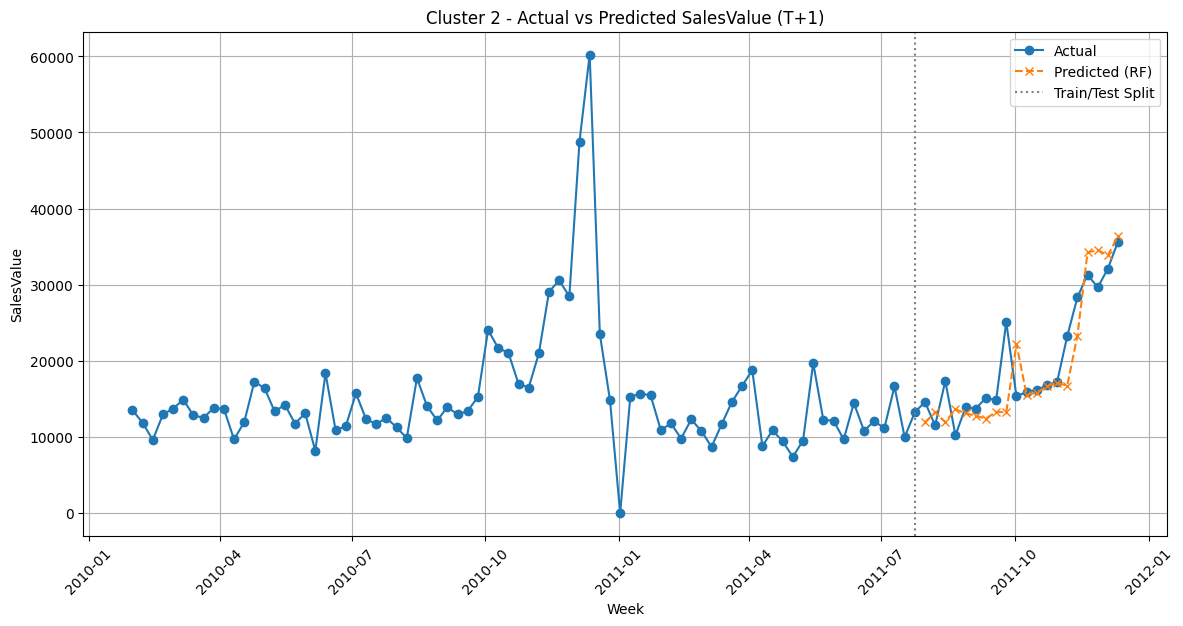

In [ ]:
def is_holiday_week(date):
    md = date.strftime('%m-%d')
    return ('12-24' <= md <= '12-31') or ('01-01' <= md <= '01-06')

def prepare_and_evaluate(cluster_df, cluster_name='cluster'):
    # Step 1: Weekly aggregation
    cluster_df = cluster_df.reset_index()  # ensure InvoiceDate is a column
    cluster_df['InvoiceDate'] = pd.to_datetime(cluster_df['InvoiceDate'])
    cluster_df.set_index('InvoiceDate', inplace=True)
    weekly_sales = cluster_df['SalesValue'].resample('W').sum().reset_index()

    # Step 2: Sliding window (T+1)
    window_size = 8
    X, y, months, holidays = [], [], [], []

    for i in range(len(weekly_sales) - window_size):
        window = weekly_sales['SalesValue'].iloc[i:i+window_size].values
        target = weekly_sales['SalesValue'].iloc[i + window_size]
        target_date = weekly_sales['InvoiceDate'].iloc[i + window_size]

        X.append(window)
        y.append(target)
        months.append(target_date.month)
        holidays.append(1 if is_holiday_week(target_date) else 0)

    df = pd.DataFrame(X, columns=[f'week_{j}' for j in range(window_size)])
    df['target'] = y
    df['month'] = months
    df['holiday'] = holidays
    df = pd.get_dummies(df, columns=['month'], prefix='month')

    # Step 3: Train-test split
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    test_df = df.iloc[split_idx:].reset_index(drop=True)

    X_train = train_df.drop(columns='target')
    y_train = train_df['target']
    X_test = test_df.drop(columns='target')
    y_test = test_df['target']

    # Step 4: Grid Search for Random Forest
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 5: Prediction and MAPE
    y_pred = best_model.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"\n📊 {cluster_name} - Best Parameters: {grid_search.best_params_}")
    print(f"📉 {cluster_name} - MAPE: {mape:.2f}%")

    # Step 6: Plot Actual vs Predicted (with aligned date axis)
    full_actual = pd.concat([train_df['target'], test_df['target']], ignore_index=True)
    full_pred = np.concatenate([np.full(len(train_df), np.nan), y_pred])

    aligned_dates = weekly_sales['InvoiceDate'].iloc[window_size:].reset_index(drop=True)

    plt.figure(figsize=(12, 6))
    plt.plot(aligned_dates, full_actual, label='Actual', marker='o')
    plt.plot(aligned_dates, full_pred, label='Predicted (RF)', marker='x', linestyle='--')
    plt.axvline(aligned_dates.iloc[len(train_df)-1], color='gray', linestyle=':', label='Train/Test Split')

    plt.title(f'{cluster_name} - Actual vs Predicted SalesValue (T+1)')
    plt.xlabel('Week')
    plt.ylabel('SalesValue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# === Apply to Cluster 0, 1, 2 ===
prepare_and_evaluate(cluster0_df, 'Cluster 0')
prepare_and_evaluate(cluster1_df, 'Cluster 1')
prepare_and_evaluate(cluster2_df, 'Cluster 2')



📊 Cluster 0 (T+2) - Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
📉 Cluster 0 (T+2) - MAPE: 21.68%


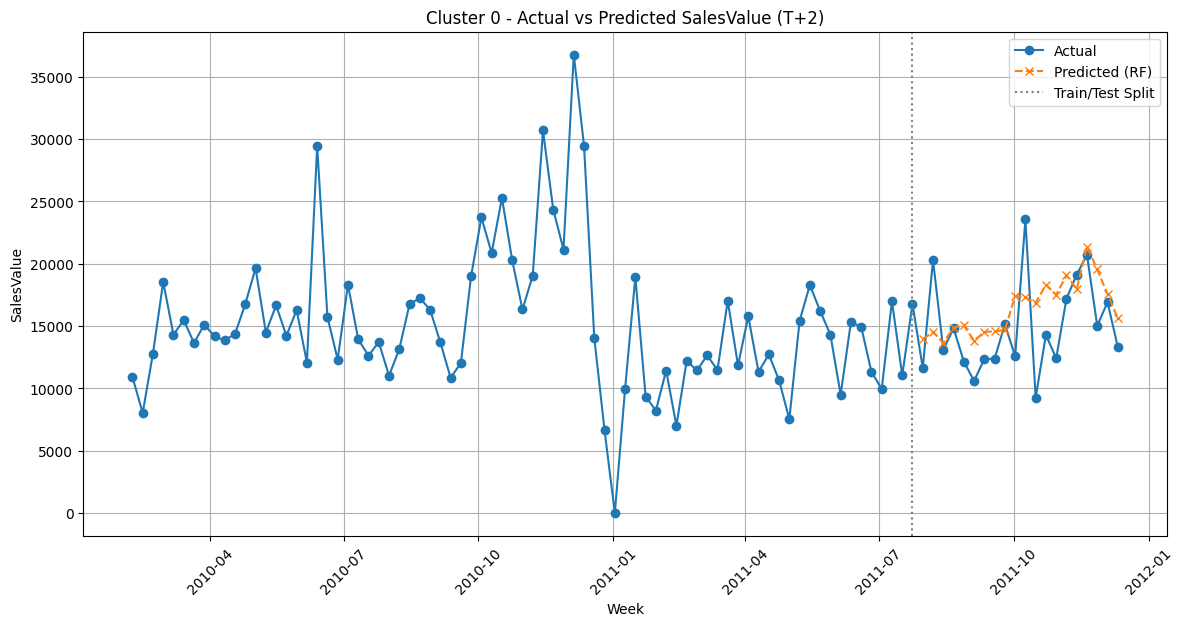


📊 Cluster 1 (T+2) - Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
📉 Cluster 1 (T+2) - MAPE: 16.21%


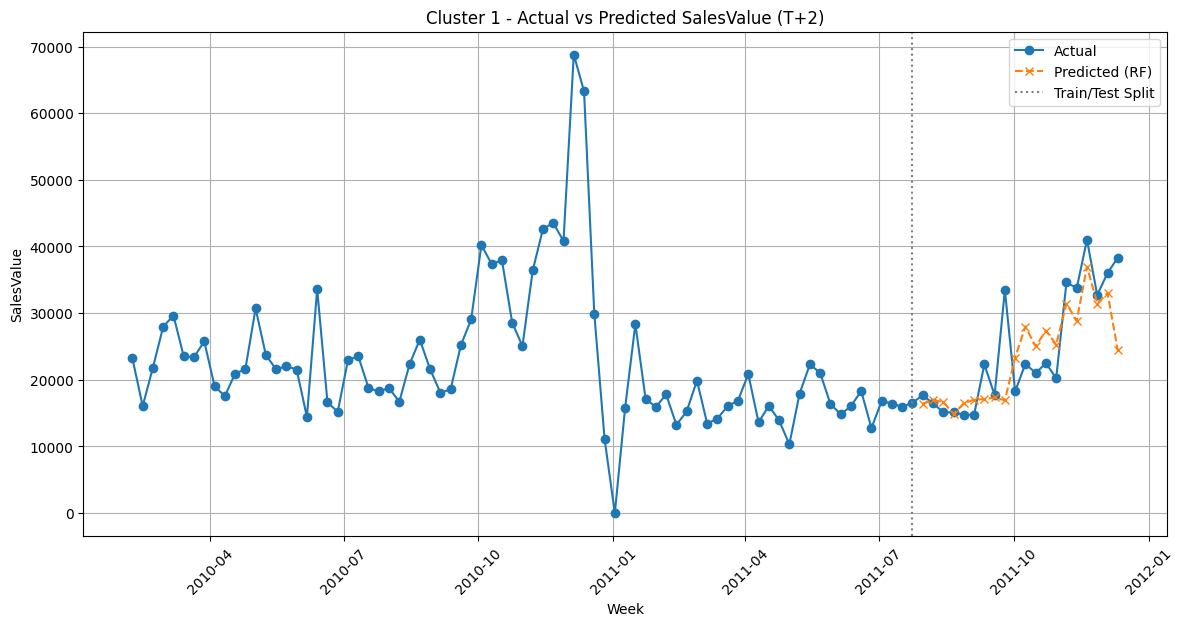


📊 Cluster 2 (T+2) - Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
📉 Cluster 2 (T+2) - MAPE: 21.60%


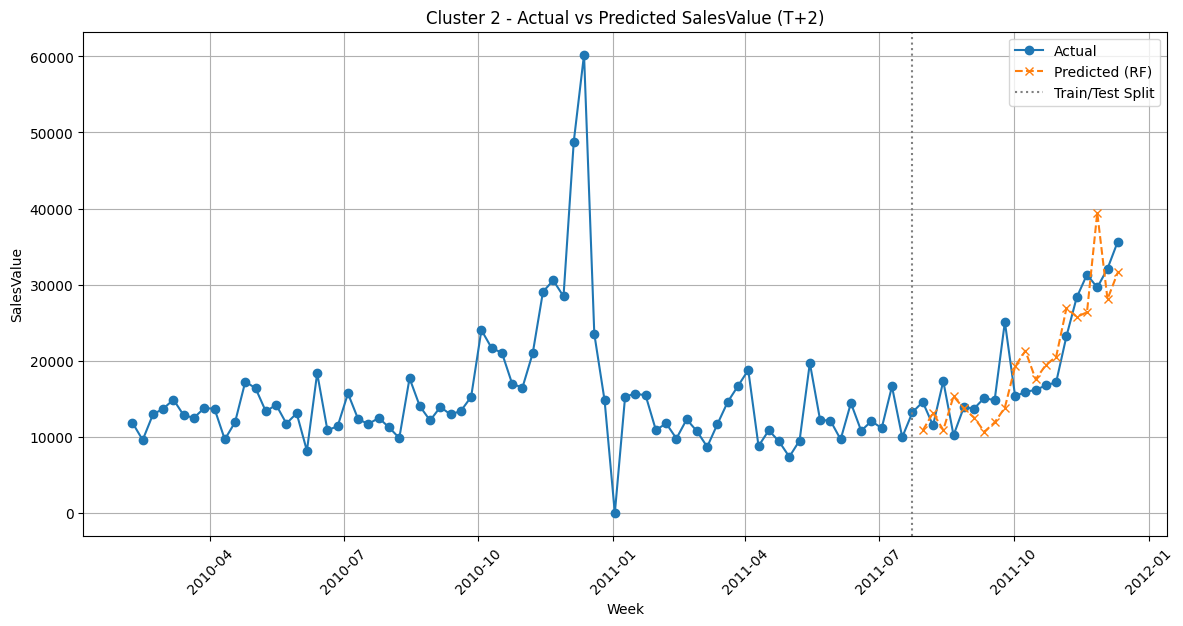

        Week    Actual     Predicted    Cluster
0 2011-07-31  11626.92  13952.630825  Cluster 0
1 2011-08-07  20296.15  14543.913018  Cluster 0
2 2011-08-14  13088.96  13662.346655  Cluster 0
3 2011-08-21  14826.69  14877.879830  Cluster 0
4 2011-08-28  12156.15  15051.895788  Cluster 0


In [ ]:
def prepare_and_evaluate_t2(cluster_df, cluster_name='cluster'):
    # Step 1: Weekly aggregation
    cluster_df = cluster_df.reset_index()
    cluster_df['InvoiceDate'] = pd.to_datetime(cluster_df['InvoiceDate'])
    cluster_df.set_index('InvoiceDate', inplace=True)
    weekly_sales = cluster_df['SalesValue'].resample('W').sum().reset_index()

    # Step 2: Sliding window (T+2)
    window_size = 8
    X, y, months, holidays = [], [], [], []

    for i in range(len(weekly_sales) - window_size - 1):  # T+2
        window = weekly_sales['SalesValue'].iloc[i:i + window_size].values
        target = weekly_sales['SalesValue'].iloc[i + window_size + 1]
        target_date = weekly_sales['InvoiceDate'].iloc[i + window_size + 1]

        X.append(window)
        y.append(target)
        months.append(target_date.month)
        holidays.append(1 if is_holiday_week(target_date) else 0)

    df = pd.DataFrame(X, columns=[f'week_{j}' for j in range(window_size)])
    df['target'] = y
    df['month'] = months
    df['holiday'] = holidays
    df = pd.get_dummies(df, columns=['month'], prefix='month')

    # Step 3: Train-test split
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    test_df = df.iloc[split_idx:].reset_index(drop=True)

    X_train = train_df.drop(columns='target')
    y_train = train_df['target']
    X_test = test_df.drop(columns='target')
    y_test = test_df['target']

    # Step 4: Grid Search for Random Forest
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 5: Prediction and MAPE
    y_pred = best_model.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"\n📊 {cluster_name} (T+2) - Best Parameters: {grid_search.best_params_}")
    print(f"📉 {cluster_name} (T+2) - MAPE: {mape:.2f}%")

    # Step 6: Plot
    full_actual = pd.concat([train_df['target'], test_df['target']], ignore_index=True)
    full_pred = np.concatenate([np.full(len(train_df), np.nan), y_pred])
    aligned_dates = weekly_sales['InvoiceDate'].iloc[window_size + 1:].reset_index(drop=True)

    plt.figure(figsize=(12, 6))
    plt.plot(aligned_dates, full_actual, label='Actual', marker='o')
    plt.plot(aligned_dates, full_pred, label='Predicted (RF)', marker='x', linestyle='--')
    plt.axvline(aligned_dates.iloc[len(train_df) - 1], color='gray', linestyle=':', label='Train/Test Split')

    plt.title(f'{cluster_name} - Actual vs Predicted SalesValue (T+2)')
    plt.xlabel('Week')
    plt.ylabel('SalesValue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # Step 7: Return test-only predictions
    result_df = pd.DataFrame({
        'Week': aligned_dates.iloc[len(train_df):].values,
        'Actual': y_test.values,
        'Predicted': y_pred,
        'Cluster': cluster_name
    })
    return result_df



df_cluster0_t2 = prepare_and_evaluate_t2(cluster0_df, 'Cluster 0')
df_cluster1_t2 = prepare_and_evaluate_t2(cluster1_df, 'Cluster 1')
df_cluster2_t2 = prepare_and_evaluate_t2(cluster2_df, 'Cluster 2')

all_predictions_t2 = pd.concat([df_cluster0_t2, df_cluster1_t2, df_cluster2_t2], ignore_index=True)

# Optional: Save
# all_predictions_t2.to_csv("all_cluster_test_predictions_T+2.csv", index=False)

print(all_predictions_t2.head())



📊 Cluster 0 (T+3) - Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📉 Cluster 0 (T+3) - MAPE: 25.68%


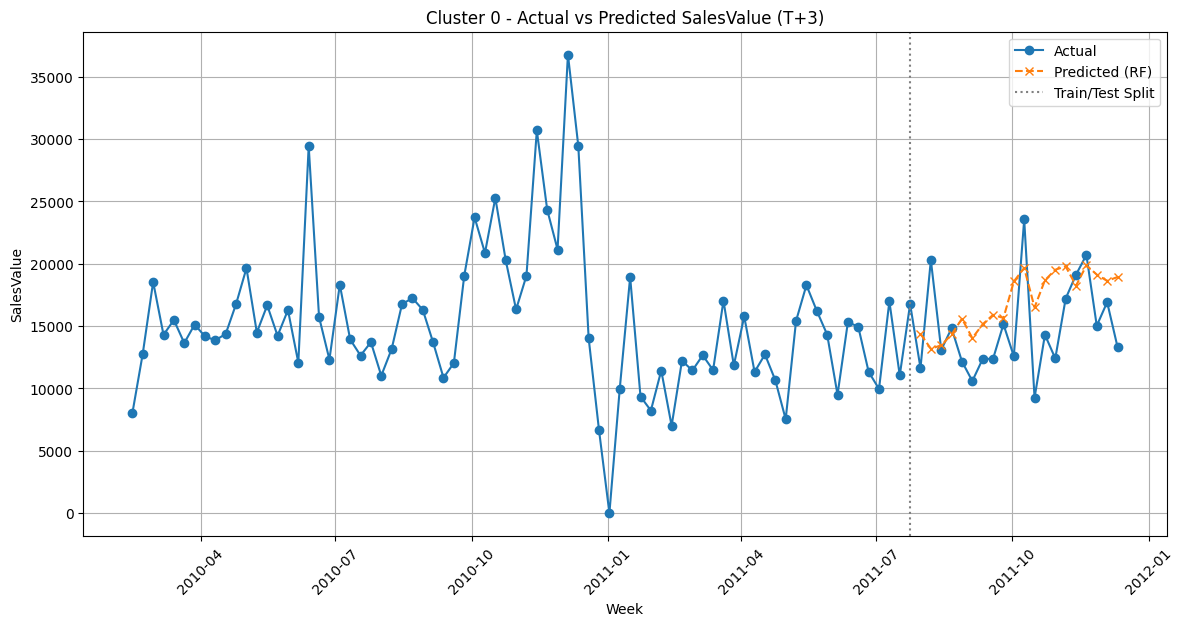


📊 Cluster 1 (T+3) - Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
📉 Cluster 1 (T+3) - MAPE: 18.82%


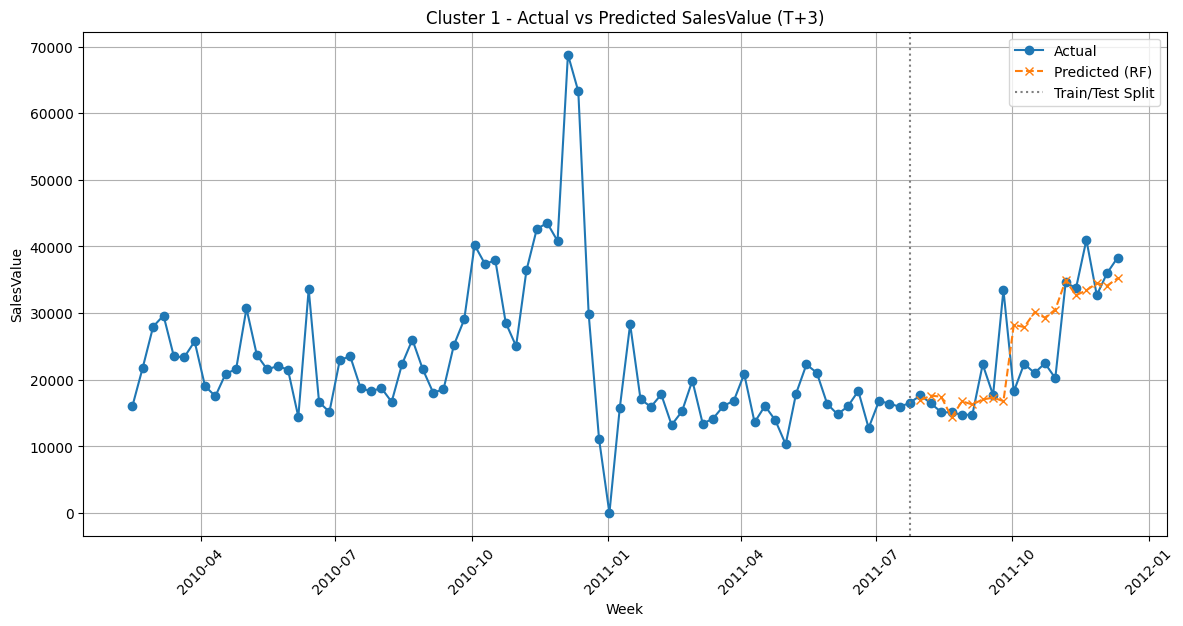


📊 Cluster 2 (T+3) - Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
📉 Cluster 2 (T+3) - MAPE: 17.23%


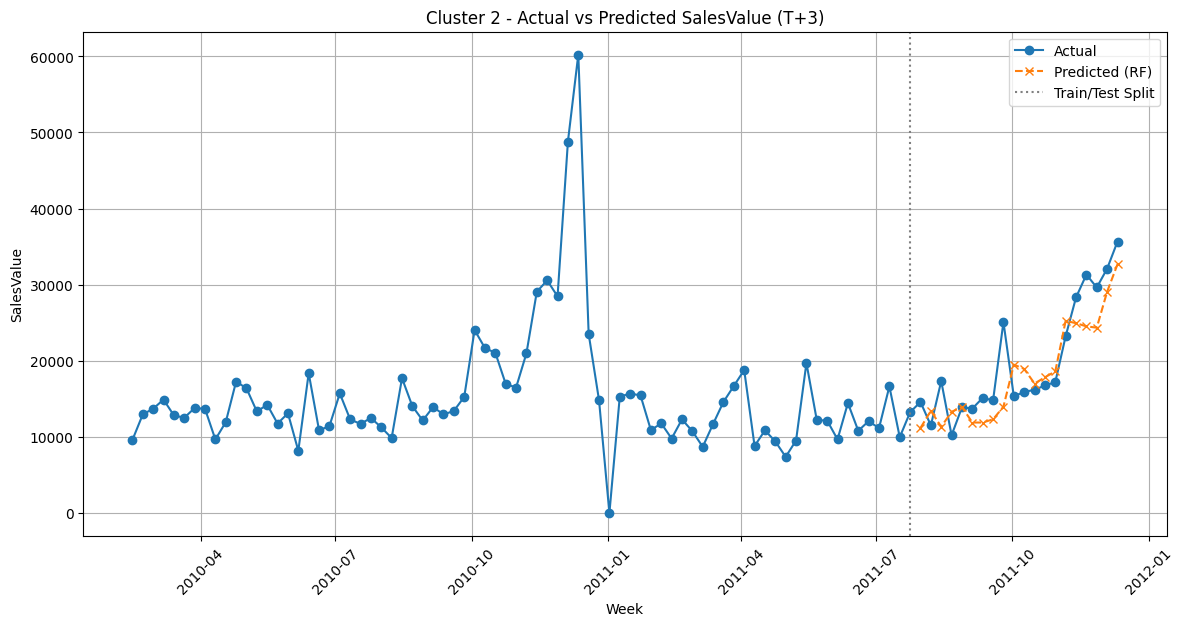

        Week    Actual     Predicted    Cluster
0 2011-07-31  11626.92  14376.190213  Cluster 0
1 2011-08-07  20296.15  13182.309776  Cluster 0
2 2011-08-14  13088.96  13454.953121  Cluster 0
3 2011-08-21  14826.69  14322.021659  Cluster 0
4 2011-08-28  12156.15  15591.167638  Cluster 0


In [ ]:
def prepare_and_evaluate_t3(cluster_df, cluster_name='cluster'):
    # Step 1: Weekly aggregation
    cluster_df = cluster_df.reset_index()
    cluster_df['InvoiceDate'] = pd.to_datetime(cluster_df['InvoiceDate'])
    cluster_df.set_index('InvoiceDate', inplace=True)
    weekly_sales = cluster_df['SalesValue'].resample('W').sum().reset_index()

    # Step 2: Sliding window (T+3)
    window_size = 8
    X, y, months, holidays = [], [], [], []

    for i in range(len(weekly_sales) - window_size - 2):  # T+3
        window = weekly_sales['SalesValue'].iloc[i:i + window_size].values
        target = weekly_sales['SalesValue'].iloc[i + window_size + 2]
        target_date = weekly_sales['InvoiceDate'].iloc[i + window_size + 2]

        X.append(window)
        y.append(target)
        months.append(target_date.month)
        holidays.append(1 if is_holiday_week(target_date) else 0)

    df = pd.DataFrame(X, columns=[f'week_{j}' for j in range(window_size)])
    df['target'] = y
    df['month'] = months
    df['holiday'] = holidays
    df = pd.get_dummies(df, columns=['month'], prefix='month')

    # Step 3: Train-test split
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    test_df = df.iloc[split_idx:].reset_index(drop=True)

    X_train = train_df.drop(columns='target')
    y_train = train_df['target']
    X_test = test_df.drop(columns='target')
    y_test = test_df['target']

    # Step 4: Grid Search for Random Forest
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 5: Prediction and MAPE
    y_pred = best_model.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"\n📊 {cluster_name} (T+3) - Best Parameters: {grid_search.best_params_}")
    print(f"📉 {cluster_name} (T+3) - MAPE: {mape:.2f}%")

    # Step 6: Plot
    full_actual = pd.concat([train_df['target'], test_df['target']], ignore_index=True)
    full_pred = np.concatenate([np.full(len(train_df), np.nan), y_pred])
    aligned_dates = weekly_sales['InvoiceDate'].iloc[window_size + 2:].reset_index(drop=True)

    plt.figure(figsize=(12, 6))
    plt.plot(aligned_dates, full_actual, label='Actual', marker='o')
    plt.plot(aligned_dates, full_pred, label='Predicted (RF)', marker='x', linestyle='--')
    plt.axvline(aligned_dates.iloc[len(train_df) - 1], color='gray', linestyle=':', label='Train/Test Split')

    plt.title(f'{cluster_name} - Actual vs Predicted SalesValue (T+3)')
    plt.xlabel('Week')
    plt.ylabel('SalesValue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # Step 7: Save test-only predictions
    result_df = pd.DataFrame({
        'Week': aligned_dates.iloc[len(train_df):].values,
        'Actual': y_test.values,
        'Predicted': y_pred,
        'Cluster': cluster_name
    })
    return result_df


df_cluster0_t3 = prepare_and_evaluate_t3(cluster0_df, 'Cluster 0')
df_cluster1_t3 = prepare_and_evaluate_t3(cluster1_df, 'Cluster 1')
df_cluster2_t3 = prepare_and_evaluate_t3(cluster2_df, 'Cluster 2')

all_predictions_t3 = pd.concat([df_cluster0_t3, df_cluster1_t3, df_cluster2_t3], ignore_index=True)

# Optional: Save to CSV
# all_predictions_t3.to_csv("all_cluster_test_predictions_T+3.csv", index=False)

print(all_predictions_t3.head())


📊 Cluster 0 - Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
📉 Cluster 0 - MAPE: 23.37%


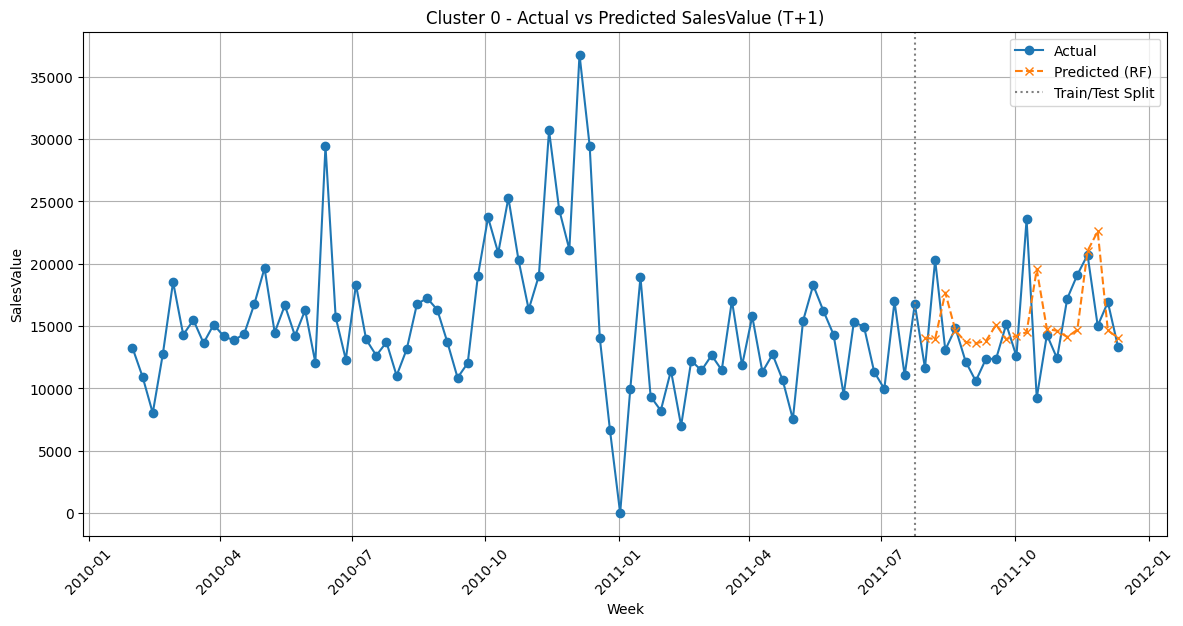


📊 Cluster 1 - Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
📉 Cluster 1 - MAPE: 18.70%


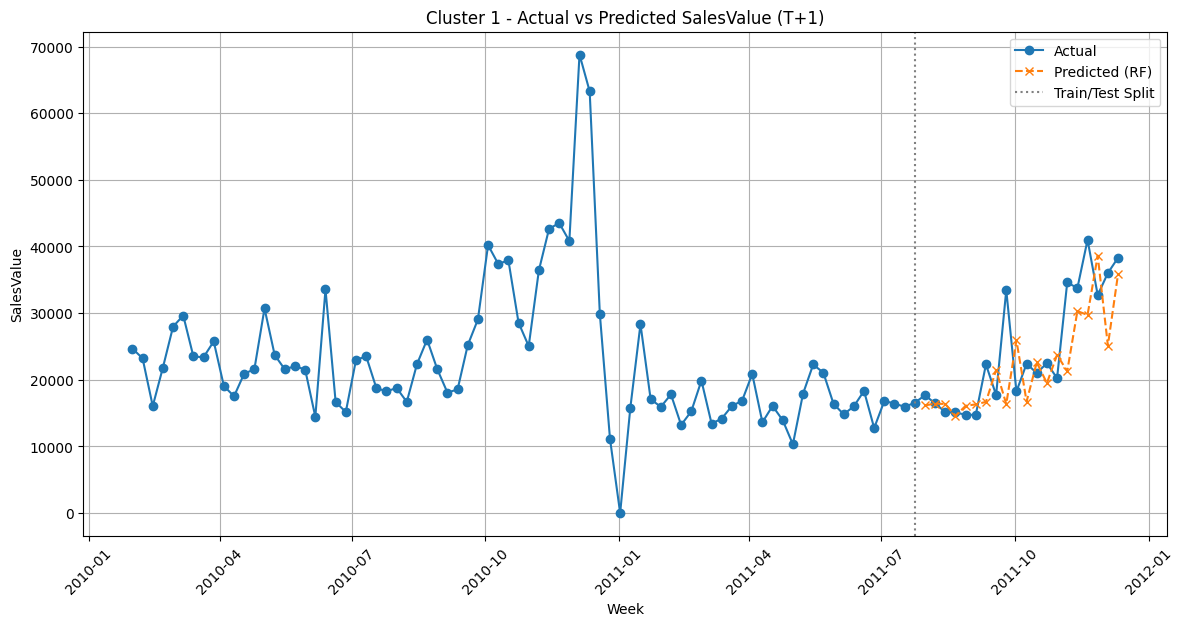


📊 Cluster 2 - Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
📉 Cluster 2 - MAPE: 15.79%


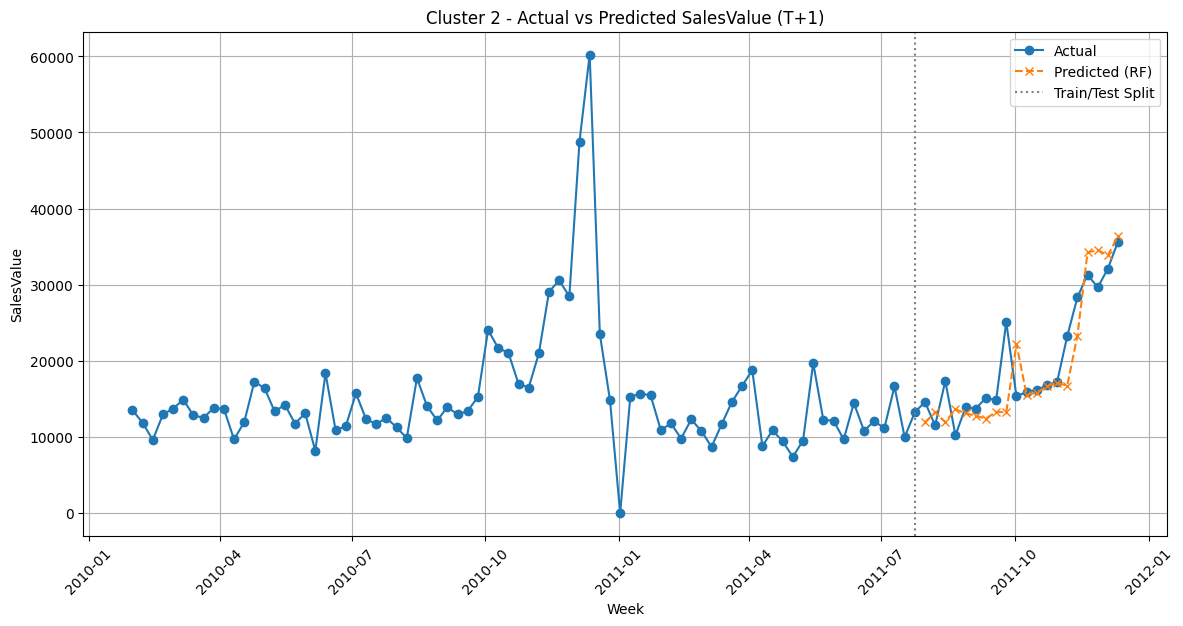

        Week    Actual     Predicted    Cluster
0 2011-07-31  11626.92  14059.014210  Cluster 0
1 2011-08-07  20296.15  13955.469010  Cluster 0
2 2011-08-14  13088.96  17682.893707  Cluster 0
3 2011-08-21  14826.69  14633.966709  Cluster 0
4 2011-08-28  12156.15  13722.427982  Cluster 0


In [ ]:
def prepare_and_evaluate(cluster_df, cluster_name='cluster'):
    # Step 1: Weekly aggregation
    cluster_df = cluster_df.reset_index()
    cluster_df['InvoiceDate'] = pd.to_datetime(cluster_df['InvoiceDate'])
    cluster_df.set_index('InvoiceDate', inplace=True)
    weekly_sales = cluster_df['SalesValue'].resample('W').sum().reset_index()

    # Step 2: Sliding window (T+1)
    window_size = 8
    X, y, months, holidays = [], [], [], []

    for i in range(len(weekly_sales) - window_size):
        window = weekly_sales['SalesValue'].iloc[i:i + window_size].values
        target = weekly_sales['SalesValue'].iloc[i + window_size]
        target_date = weekly_sales['InvoiceDate'].iloc[i + window_size]

        X.append(window)
        y.append(target)
        months.append(target_date.month)
        holidays.append(1 if is_holiday_week(target_date) else 0)

    df = pd.DataFrame(X, columns=[f'week_{j}' for j in range(window_size)])
    df['target'] = y
    df['month'] = months
    df['holiday'] = holidays
    df = pd.get_dummies(df, columns=['month'], prefix='month')

    # Step 3: Train-test split
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    test_df = df.iloc[split_idx:].reset_index(drop=True)

    X_train = train_df.drop(columns='target')
    y_train = train_df['target']
    X_test = test_df.drop(columns='target')
    y_test = test_df['target']

    # Step 4: Grid Search for Random Forest
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 5: Prediction and MAPE
    y_pred = best_model.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"\n📊 {cluster_name} - Best Parameters: {grid_search.best_params_}")
    print(f"📉 {cluster_name} - MAPE: {mape:.2f}%")

    # Step 6: Plot Actual vs Predicted
    full_actual = pd.concat([train_df['target'], test_df['target']], ignore_index=True)
    full_pred = np.concatenate([np.full(len(train_df), np.nan), y_pred])
    aligned_dates = weekly_sales['InvoiceDate'].iloc[window_size:].reset_index(drop=True)

    plt.figure(figsize=(12, 6))
    plt.plot(aligned_dates, full_actual, label='Actual', marker='o')
    plt.plot(aligned_dates, full_pred, label='Predicted (RF)', marker='x', linestyle='--')
    plt.axvline(aligned_dates.iloc[len(train_df) - 1], color='gray', linestyle=':', label='Train/Test Split')
    plt.title(f'{cluster_name} - Actual vs Predicted SalesValue (T+1)')
    plt.xlabel('Week')
    plt.ylabel('SalesValue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # Step 7: Save test-only predictions
    result_df = pd.DataFrame({
        'Week': aligned_dates.iloc[len(train_df):].values,
        'Actual': y_test.values,
        'Predicted': y_pred,
        'Cluster': cluster_name
    })
    return result_df

df_cluster0 = prepare_and_evaluate(cluster0_df, 'Cluster 0')
df_cluster1 = prepare_and_evaluate(cluster1_df, 'Cluster 1')
df_cluster2 = prepare_and_evaluate(cluster2_df, 'Cluster 2')

# Combine and save only the test predictions
all_predictions_T1 = pd.concat([df_cluster0, df_cluster1, df_cluster2], ignore_index=True)
all_predictions_T1.to_csv("all_cluster_test_predictions_T+1.csv", index=False)

print(all_predictions_T1.head())


In [ ]:
# Save to Google Drive folder
all_predictions_T1.to_csv("/content/drive/My Drive/forecasting/predictions_T1.csv", index=False)
all_predictions_t2.to_csv("/content/drive/My Drive/forecasting/predictions_T2.csv", index=False)
all_predictions_t3.to_csv("/content/drive/My Drive/forecasting/predictions_T3.csv", index=False)


In [ ]:
all_predictions_t3

Week    Actual     Predicted    Cluster
0  2011-07-31  11626.92  14376.190213  Cluster 0
1  2011-08-07  20296.15  13182.309776  Cluster 0
2  2011-08-14  13088.96  13454.953121  Cluster 0
3  2011-08-21  14826.69  14322.021659  Cluster 0
4  2011-08-28  12156.15  15591.167638  Cluster 0
5  2011-09-04  10589.82  14034.722826  Cluster 0
6  2011-09-11  12361.37  15143.316711  Cluster 0
7  2011-09-18  12375.67  15902.140945  Cluster 0
8  2011-09-25  15145.70  15643.775338  Cluster 0
9  2011-10-02  12576.21  18573.162900  Cluster 0
10 2011-10-09  23546.05  19661.272621  Cluster 0
11 2011-10-16   9244.47  16492.029857  Cluster 0
12 2011-10-23  14299.59  18671.818160  Cluster 0
13 2011-10-30  12402.83  19516.371565  Cluster 0
14 2011-11-06  17196.84  19784.947264  Cluster 0
15 2011-11-13  19119.08  18235.215616  Cluster 0
16 2011-11-20  20706.48  19863.798330  Cluster 0
17 2011-11-27  15021.31  19128.330495  Cluster 0
18 2011-12-04  16914.08  18620.102638  Cluster 0
19 2011-12-11  13331.89  18932.462092  Cluster 0
20 2011-07-31  17680.58  16942.305964  Cluster 1
21 2011-08-07  16452.51  17620.540087  Cluster 1
22 2011-08-14  15142.92  17457.073715  Cluster 1
23 2011-08-21  15092.67  14367.453759  Cluster 1
24 2011-08-28  14747.60  16758.869063  Cluster 1
25 2011-09-04  14741.08  16300.403218  Cluster 1
26 2011-09-11  22301.37  17046.566369  Cluster 1
27 2011-09-18  17713.28  17309.705558  Cluster 1
28 2011-09-25  33454.81  16799.257595  Cluster 1
29 2011-10-02  18240.34  28232.169007  Cluster 1
30 2011-10-09  22402.37  27909.823384  Cluster 1
31 2011-10-16  21009.32  30105.400915  Cluster 1
32 2011-10-23  22480.90  29312.050318  Cluster 1
33 2011-10-30  20236.36  30525.063472  Cluster 1
34 2011-11-06  34605.93  34896.535465  Cluster 1
35 2011-11-13  33748.73  32675.980247  Cluster 1
36 2011-11-20  40997.13  33419.651174  Cluster 1
37 2011-11-27  32703.04  34484.205584  Cluster 1
38 2011-12-04  36011.32  34116.602092  Cluster 1
39 2011-12-11  38305.60  35223.709263  Cluster 1
40 2011-07-31  14592.96  11181.141010  Cluster 2
41 2011-08-07  11508.23  13423.857331  Cluster 2
42 2011-08-14  17337.06  11340.543044  Cluster 2
43 2011-08-21  10219.78  13300.732583  Cluster 2
44 2011-08-28  13889.64  13929.885818  Cluster 2
45 2011-09-04  13727.11  11893.103338  Cluster 2
46 2011-09-11  15132.38  11892.205490  Cluster 2
47 2011-09-18  14800.14  12315.395306  Cluster 2
48 2011-09-25  25103.58  13977.959825  Cluster 2
49 2011-10-02  15341.01  19495.122336  Cluster 2
50 2011-10-09  15913.02  18935.222809  Cluster 2
51 2011-10-16  16188.38  17016.287889  Cluster 2
52 2011-10-23  16762.40  17834.643331  Cluster 2
53 2011-10-30  17197.95  18609.959477  Cluster 2
54 2011-11-06  23236.88  25253.729283  Cluster 2
55 2011-11-13  28326.17  24945.335460  Cluster 2
56 2011-11-20  31328.74  24527.486232  Cluster 2
57 2011-11-27  29632.91  24354.607505  Cluster 2
58 2011-12-04  32108.56  29081.040609  Cluster 2
59 2011-12-11  35663.03  32685.478654  Cluster 2

In [ ]:
all_predictions_t2

Week    Actual     Predicted    Cluster
0  2011-07-31  11626.92  13952.630825  Cluster 0
1  2011-08-07  20296.15  14543.913018  Cluster 0
2  2011-08-14  13088.96  13662.346655  Cluster 0
3  2011-08-21  14826.69  14877.879830  Cluster 0
4  2011-08-28  12156.15  15051.895788  Cluster 0
5  2011-09-04  10589.82  13822.389712  Cluster 0
6  2011-09-11  12361.37  14529.136240  Cluster 0
7  2011-09-18  12375.67  14578.110187  Cluster 0
8  2011-09-25  15145.70  14670.039983  Cluster 0
9  2011-10-02  12576.21  17413.968346  Cluster 0
10 2011-10-09  23546.05  17311.021705  Cluster 0
11 2011-10-16   9244.47  16845.541346  Cluster 0
12 2011-10-23  14299.59  18321.406096  Cluster 0
13 2011-10-30  12402.83  17507.443496  Cluster 0
14 2011-11-06  17196.84  19067.735314  Cluster 0
15 2011-11-13  19119.08  17958.787443  Cluster 0
16 2011-11-20  20706.48  21362.759057  Cluster 0
17 2011-11-27  15021.31  19541.773584  Cluster 0
18 2011-12-04  16914.08  17581.480280  Cluster 0
19 2011-12-11  13331.89  15617.456367  Cluster 0
20 2011-07-31  17680.58  16401.952821  Cluster 1
21 2011-08-07  16452.51  16909.910702  Cluster 1
22 2011-08-14  15142.92  16685.669269  Cluster 1
23 2011-08-21  15092.67  14871.662811  Cluster 1
24 2011-08-28  14747.60  16460.559872  Cluster 1
25 2011-09-04  14741.08  17015.521618  Cluster 1
26 2011-09-11  22301.37  17095.471660  Cluster 1
27 2011-09-18  17713.28  17338.568127  Cluster 1
28 2011-09-25  33454.81  16910.999603  Cluster 1
29 2011-10-02  18240.34  23337.173848  Cluster 1
30 2011-10-09  22402.37  27978.586940  Cluster 1
31 2011-10-16  21009.32  25000.794725  Cluster 1
32 2011-10-23  22480.90  27376.438869  Cluster 1
33 2011-10-30  20236.36  25281.243082  Cluster 1
34 2011-11-06  34605.93  31428.993861  Cluster 1
35 2011-11-13  33748.73  28817.668841  Cluster 1
36 2011-11-20  40997.13  36977.400795  Cluster 1
37 2011-11-27  32703.04  31425.321140  Cluster 1
38 2011-12-04  36011.32  33035.701905  Cluster 1
39 2011-12-11  38305.60  24413.831701  Cluster 1
40 2011-07-31  14592.96  10857.655800  Cluster 2
41 2011-08-07  11508.23  13156.751200  Cluster 2
42 2011-08-14  17337.06  10910.938800  Cluster 2
43 2011-08-21  10219.78  15339.046600  Cluster 2
44 2011-08-28  13889.64  13747.130200  Cluster 2
45 2011-09-04  13727.11  12550.366400  Cluster 2
46 2011-09-11  15132.38  10685.759800  Cluster 2
47 2011-09-18  14800.14  11902.962600  Cluster 2
48 2011-09-25  25103.58  13849.119600  Cluster 2
49 2011-10-02  15341.01  19280.524000  Cluster 2
50 2011-10-09  15913.02  21311.761800  Cluster 2
51 2011-10-16  16188.38  17568.319400  Cluster 2
52 2011-10-23  16762.40  19470.454000  Cluster 2
53 2011-10-30  17197.95  20549.057800  Cluster 2
54 2011-11-06  23236.88  26918.316000  Cluster 2
55 2011-11-13  28326.17  25775.872400  Cluster 2
56 2011-11-20  31328.74  26376.383800  Cluster 2
57 2011-11-27  29632.91  39462.098200  Cluster 2
58 2011-12-04  32108.56  28099.698400  Cluster 2
59 2011-12-11  35663.03  31605.576400  Cluster 2

In [ ]:
df_njy = pd.read_csv("/content/drive/My Drive/forecasting/cluster0_combined_forecasts.csv")
df_njy

ds    Actual   Forecast_t1   Forecast_t2   Forecast_t3
0    2009-11-30  31579.79           NaN           NaN           NaN
1    2009-12-07  26370.31           NaN           NaN           NaN
2    2009-12-14  21643.01           NaN           NaN           NaN
3    2009-12-21   3094.75           NaN           NaN           NaN
4    2010-01-04  20411.84           NaN           NaN           NaN
..          ...       ...           ...           ...           ...
99   2011-11-07  19119.08  14526.982717  14612.899165  14020.860809
100  2011-11-14  20706.48  15157.601267  14526.982717  14612.899165
101  2011-11-21  15021.31  18057.448169  15157.601267  14526.982717
102  2011-11-28  16914.08  16461.438382  18057.448169  15157.601267
103  2011-12-05  13331.89  16745.477850  16461.438382  18057.448169

[104 rows x 5 columns]

In [ ]:
df_njy_filtered = df_njy[df_njy['ds'] > '2011-07-18']
df_njy_filtered

ds    Actual   Forecast_t1   Forecast_t2   Forecast_t3
84   2011-07-25  11626.92  14538.118984  12943.525567  13781.371578
85   2011-08-01  20296.15  13501.045524  14538.118984  12943.525567
86   2011-08-08  13088.96  14367.741530  13501.045524  14538.118984
87   2011-08-15  14826.69  14148.925803  14367.741530  13501.045524
88   2011-08-22  12156.15  14864.173666  14148.925803  14367.741530
89   2011-08-29  10589.82  14710.400798  14864.173666  14148.925803
90   2011-09-05  12361.37  13149.567627  14710.400798  14864.173666
91   2011-09-12  12375.67  12456.221978  13149.567627  14710.400798
92   2011-09-19  15145.70  13216.598846  12456.221978  13149.567627
93   2011-09-26  12576.21  14799.682193  13216.598846  12456.221978
94   2011-10-03  23546.05  12785.555427  14799.682193  13216.598846
95   2011-10-10   9244.47  14802.898596  12785.555427  14799.682193
96   2011-10-17  14299.59  14206.081401  14802.898596  12785.555427
97   2011-10-24  12402.83  14020.860809  14206.081401  14802.898596
98   2011-10-31  17196.84  14612.899165  14020.860809  14206.081401
99   2011-11-07  19119.08  14526.982717  14612.899165  14020.860809
100  2011-11-14  20706.48  15157.601267  14526.982717  14612.899165
101  2011-11-21  15021.31  18057.448169  15157.601267  14526.982717
102  2011-11-28  16914.08  16461.438382  18057.448169  15157.601267
103  2011-12-05  13331.89  16745.477850  16461.438382  18057.448169

In [ ]:
all_predictions_T1

Week    Actual     Predicted    Cluster
0  2011-07-31  11626.92  14059.014210  Cluster 0
1  2011-08-07  20296.15  13955.469010  Cluster 0
2  2011-08-14  13088.96  17682.893707  Cluster 0
3  2011-08-21  14826.69  14633.966709  Cluster 0
4  2011-08-28  12156.15  13722.427982  Cluster 0
5  2011-09-04  10589.82  13621.601908  Cluster 0
6  2011-09-11  12361.37  13804.369077  Cluster 0
7  2011-09-18  12375.67  15095.679841  Cluster 0
8  2011-09-25  15145.70  13943.486746  Cluster 0
9  2011-10-02  12576.21  14228.511569  Cluster 0
10 2011-10-09  23546.05  14501.898533  Cluster 0
11 2011-10-16   9244.47  19535.929563  Cluster 0
12 2011-10-23  14299.59  14755.275472  Cluster 0
13 2011-10-30  12402.83  14626.017061  Cluster 0
14 2011-11-06  17196.84  14116.319177  Cluster 0
15 2011-11-13  19119.08  14711.845982  Cluster 0
16 2011-11-20  20706.48  21031.291436  Cluster 0
17 2011-11-27  15021.31  22588.300474  Cluster 0
18 2011-12-04  16914.08  14647.073714  Cluster 0
19 2011-12-11  13331.89  14062.496393  Cluster 0
20 2011-07-31  17680.58  16159.649392  Cluster 1
21 2011-08-07  16452.51  16413.696582  Cluster 1
22 2011-08-14  15142.92  16372.836458  Cluster 1
23 2011-08-21  15092.67  14589.786359  Cluster 1
24 2011-08-28  14747.60  16087.978774  Cluster 1
25 2011-09-04  14741.08  16305.979779  Cluster 1
26 2011-09-11  22301.37  16679.700250  Cluster 1
27 2011-09-18  17713.28  21472.651376  Cluster 1
28 2011-09-25  33454.81  16358.158258  Cluster 1
29 2011-10-02  18240.34  25924.420084  Cluster 1
30 2011-10-09  22402.37  16724.702798  Cluster 1
31 2011-10-16  21009.32  22590.925037  Cluster 1
32 2011-10-23  22480.90  19498.747593  Cluster 1
33 2011-10-30  20236.36  23733.355119  Cluster 1
34 2011-11-06  34605.93  21268.515862  Cluster 1
35 2011-11-13  33748.73  30299.635572  Cluster 1
36 2011-11-20  40997.13  29727.264818  Cluster 1
37 2011-11-27  32703.04  38634.748250  Cluster 1
38 2011-12-04  36011.32  25134.303850  Cluster 1
39 2011-12-11  38305.60  35853.075800  Cluster 1
40 2011-07-31  14592.96  11920.711220  Cluster 2
41 2011-08-07  11508.23  13234.631631  Cluster 2
42 2011-08-14  17337.06  11942.108154  Cluster 2
43 2011-08-21  10219.78  13623.180654  Cluster 2
44 2011-08-28  13889.64  13104.302357  Cluster 2
45 2011-09-04  13727.11  12778.339759  Cluster 2
46 2011-09-11  15132.38  12409.566955  Cluster 2
47 2011-09-18  14800.14  13287.275038  Cluster 2
48 2011-09-25  25103.58  13234.631631  Cluster 2
49 2011-10-02  15341.01  22212.653939  Cluster 2
50 2011-10-09  15913.02  15536.100393  Cluster 2
51 2011-10-16  16188.38  15808.700353  Cluster 2
52 2011-10-23  16762.40  16656.972115  Cluster 2
53 2011-10-30  17197.95  17094.386459  Cluster 2
54 2011-11-06  23236.88  16747.025969  Cluster 2
55 2011-11-13  28326.17  23274.405401  Cluster 2
56 2011-11-20  31328.74  34241.812144  Cluster 2
57 2011-11-27  29632.91  34559.405084  Cluster 2
58 2011-12-04  32108.56  33846.100689  Cluster 2
59 2011-12-11  35663.03  36401.666322  Cluster 2

<Figure size 1200x600 with 0 Axes>

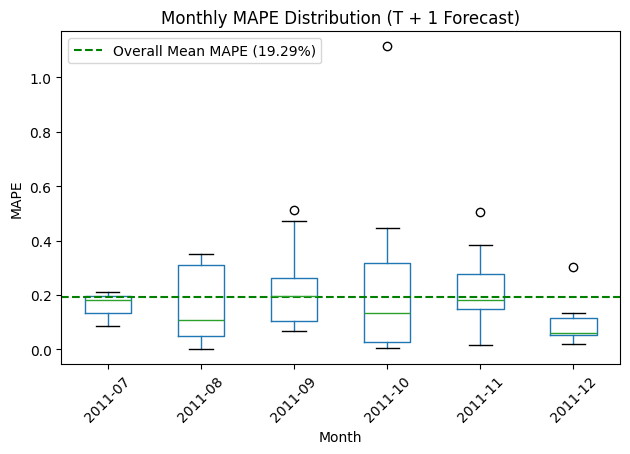

In [ ]:
# Simulate the DataFrame (in practice, replace this with actual df)
# Example assumes 'all_predictions_T1' is already defined

# Step 1: Ensure datetime
all_predictions_T1['Week'] = pd.to_datetime(all_predictions_T1['Week'])

# Step 2: Calculate APE
all_predictions_T1['APE'] = abs(all_predictions_T1['Actual'] - all_predictions_T1['Predicted']) / all_predictions_T1['Actual']

# Step 3: Extract Month
all_predictions_T1['Month'] = all_predictions_T1['Week'].dt.to_period('M').astype(str)

# Step 4: Plot
plt.figure(figsize=(12, 6))

# Boxplot of APE by Month
all_predictions_T1.boxplot(column='APE', by='Month', grid=False)
# Overall mean line (green)
overall_mean_mape = all_predictions_T1['APE'].mean()
plt.axhline(y=overall_mean_mape, color='green', linestyle='--', label=f'Overall Mean MAPE ({overall_mean_mape:.2%})')

# Final formatting
plt.title('Monthly MAPE Distribution (T + 1 Forecast)')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

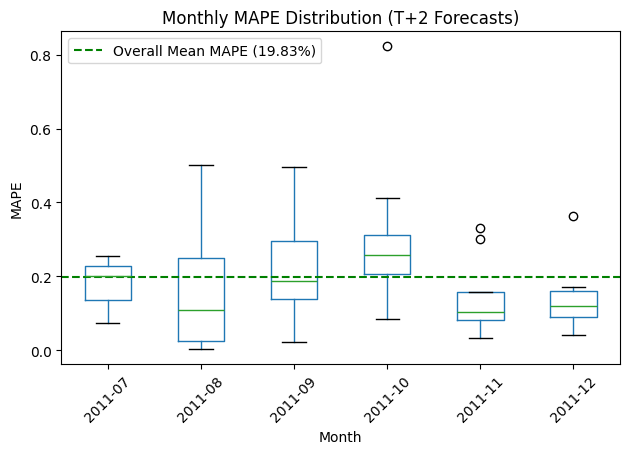

In [ ]:
all_predictions_T2 = all_predictions_t2.copy()

# Ensure Week is datetime
all_predictions_T2['Week'] = pd.to_datetime(all_predictions_T2['Week'])

# Calculate APE
all_predictions_T2['APE'] = abs(all_predictions_T2['Actual'] - all_predictions_T2['Predicted']) / all_predictions_T2['Actual']

# Extract Month
all_predictions_T2['Month'] = all_predictions_T2['Week'].dt.to_period('M').astype(str)

# Plot
plt.figure(figsize=(12, 6))
all_predictions_T2.boxplot(column='APE', by='Month', grid=False)

# Add overall mean MAPE line
overall_mean = all_predictions_T2['APE'].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', label=f'Overall Mean MAPE ({overall_mean:.2%})')

plt.title('Monthly MAPE Distribution (T+2 Forecasts)')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
all_predictions_t3

Week    Actual     Predicted    Cluster
0  2011-07-31  11626.92  14376.190213  Cluster 0
1  2011-08-07  20296.15  13182.309776  Cluster 0
2  2011-08-14  13088.96  13454.953121  Cluster 0
3  2011-08-21  14826.69  14322.021659  Cluster 0
4  2011-08-28  12156.15  15591.167638  Cluster 0
5  2011-09-04  10589.82  14034.722826  Cluster 0
6  2011-09-11  12361.37  15143.316711  Cluster 0
7  2011-09-18  12375.67  15902.140945  Cluster 0
8  2011-09-25  15145.70  15643.775338  Cluster 0
9  2011-10-02  12576.21  18573.162900  Cluster 0
10 2011-10-09  23546.05  19661.272621  Cluster 0
11 2011-10-16   9244.47  16492.029857  Cluster 0
12 2011-10-23  14299.59  18671.818160  Cluster 0
13 2011-10-30  12402.83  19516.371565  Cluster 0
14 2011-11-06  17196.84  19784.947264  Cluster 0
15 2011-11-13  19119.08  18235.215616  Cluster 0
16 2011-11-20  20706.48  19863.798330  Cluster 0
17 2011-11-27  15021.31  19128.330495  Cluster 0
18 2011-12-04  16914.08  18620.102638  Cluster 0
19 2011-12-11  13331.89  18932.462092  Cluster 0
20 2011-07-31  17680.58  16942.305964  Cluster 1
21 2011-08-07  16452.51  17620.540087  Cluster 1
22 2011-08-14  15142.92  17457.073715  Cluster 1
23 2011-08-21  15092.67  14367.453759  Cluster 1
24 2011-08-28  14747.60  16758.869063  Cluster 1
25 2011-09-04  14741.08  16300.403218  Cluster 1
26 2011-09-11  22301.37  17046.566369  Cluster 1
27 2011-09-18  17713.28  17309.705558  Cluster 1
28 2011-09-25  33454.81  16799.257595  Cluster 1
29 2011-10-02  18240.34  28232.169007  Cluster 1
30 2011-10-09  22402.37  27909.823384  Cluster 1
31 2011-10-16  21009.32  30105.400915  Cluster 1
32 2011-10-23  22480.90  29312.050318  Cluster 1
33 2011-10-30  20236.36  30525.063472  Cluster 1
34 2011-11-06  34605.93  34896.535465  Cluster 1
35 2011-11-13  33748.73  32675.980247  Cluster 1
36 2011-11-20  40997.13  33419.651174  Cluster 1
37 2011-11-27  32703.04  34484.205584  Cluster 1
38 2011-12-04  36011.32  34116.602092  Cluster 1
39 2011-12-11  38305.60  35223.709263  Cluster 1
40 2011-07-31  14592.96  11181.141010  Cluster 2
41 2011-08-07  11508.23  13423.857331  Cluster 2
42 2011-08-14  17337.06  11340.543044  Cluster 2
43 2011-08-21  10219.78  13300.732583  Cluster 2
44 2011-08-28  13889.64  13929.885818  Cluster 2
45 2011-09-04  13727.11  11893.103338  Cluster 2
46 2011-09-11  15132.38  11892.205490  Cluster 2
47 2011-09-18  14800.14  12315.395306  Cluster 2
48 2011-09-25  25103.58  13977.959825  Cluster 2
49 2011-10-02  15341.01  19495.122336  Cluster 2
50 2011-10-09  15913.02  18935.222809  Cluster 2
51 2011-10-16  16188.38  17016.287889  Cluster 2
52 2011-10-23  16762.40  17834.643331  Cluster 2
53 2011-10-30  17197.95  18609.959477  Cluster 2
54 2011-11-06  23236.88  25253.729283  Cluster 2
55 2011-11-13  28326.17  24945.335460  Cluster 2
56 2011-11-20  31328.74  24527.486232  Cluster 2
57 2011-11-27  29632.91  24354.607505  Cluster 2
58 2011-12-04  32108.56  29081.040609  Cluster 2
59 2011-12-11  35663.03  32685.478654  Cluster 2

<Figure size 1200x600 with 0 Axes>

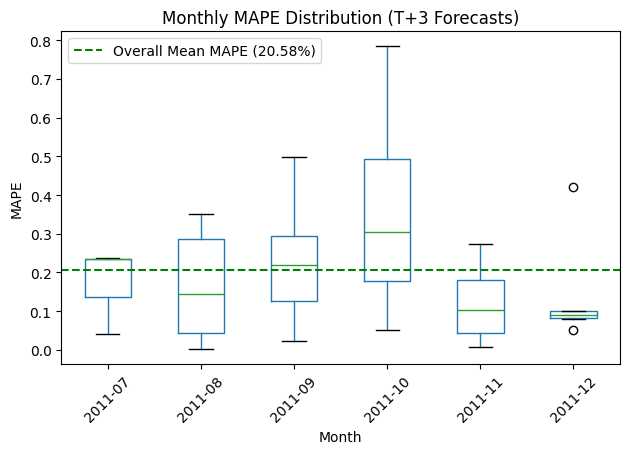

In [ ]:
# Convert 'Week' to datetime
all_predictions_t3['Week'] = pd.to_datetime(all_predictions_t3['Week'])

# Compute APE
all_predictions_t3['APE'] = abs(all_predictions_t3['Actual'] - all_predictions_t3['Predicted']) / all_predictions_t3['Actual']

# Extract Month
all_predictions_t3['Month'] = all_predictions_t3['Week'].dt.to_period('M').astype(str)

# Plot boxplot without monthly average line
plt.figure(figsize=(12, 6))
all_predictions_t3.boxplot(column='APE', by='Month', grid=False)

# Add overall mean MAPE line
overall_mean = all_predictions_t3['APE'].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', label=f'Overall Mean MAPE ({overall_mean:.2%})')

# Final formatting
plt.title('Monthly MAPE Distribution (T+3 Forecasts)')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
cluster0_df

Invoice StockCode                          Description  \
InvoiceDate                                                                  
2009-12-01 09:06:00  489436     84879        ASSORTED COLOUR BIRD ORNAMENT   
2009-12-01 09:06:00  489436    84596F         SMALL MARSHMALLOWS PINK BOWL   
2009-12-01 09:08:00  489437     20971     PINK BLUE FELT CRAFT TRINKET BOX   
2009-12-01 09:08:00  489437     22274                 FELTCRAFT DOLL EMILY   
2009-12-01 09:24:00  489438     21411          GINGHAM HEART  DOORSTOP RED   
...                     ...       ...                                  ...   
2011-12-09 12:20:00  581580    85049E            SCANDINAVIAN REDS RIBBONS   
2011-12-09 12:31:00  581585     84879        ASSORTED COLOUR BIRD ORNAMENT   
2011-12-09 12:31:00  581585     21916      SET 12 RETRO WHITE CHALK STICKS   
2011-12-09 12:31:00  581585     84692          BOX OF 24 COCKTAIL PARASOLS   
2011-12-09 12:49:00  581586     22061  LARGE CAKE STAND  HANGING STRAWBERY   

                     Quantity  Price  Customer ID         Country YearMonth  \
InvoiceDate                                                                   
2009-12-01 09:06:00        16   1.69      13078.0  United Kingdom   2009-12   
2009-12-01 09:06:00         8   1.25      13078.0  United Kingdom   2009-12   
2009-12-01 09:08:00        12   1.25      15362.0  United Kingdom   2009-12   
2009-12-01 09:08:00         6   2.95      15362.0  United Kingdom   2009-12   
2009-12-01 09:24:00        32   2.50      18102.0  United Kingdom   2009-12   
...                       ...    ...          ...             ...       ...   
2011-12-09 12:20:00         2   1.25      12748.0  United Kingdom   2011-12   
2011-12-09 12:31:00        16   1.69      15804.0  United Kingdom   2011-12   
2011-12-09 12:31:00        24   0.42      15804.0  United Kingdom   2011-12   
2011-12-09 12:31:00        25   0.42      15804.0  United Kingdom   2011-12   
2011-12-09 12:49:00         8   2.95      13113.0  United Kingdom   2011-12   

                    SP500_Close   CPI  data_based_cluster  desc_based_cluster  \
InvoiceDate                                                                     
2009-12-01 09:06:00    1,115.10  2.51                   6                   1   
2009-12-01 09:06:00    1,115.10  2.51                   3                   2   
2009-12-01 09:08:00    1,115.10  2.51                   5                   6   
2009-12-01 09:08:00    1,115.10  2.51                   7                   4   
2009-12-01 09:24:00    1,115.10  2.51                   4                   7   
...                         ...   ...                 ...                 ...   
2011-12-09 12:20:00    1,257.60  3.69                   6                   4   
2011-12-09 12:31:00    1,257.60  3.69                   6                   1   
2011-12-09 12:31:00    1,257.60  3.69                   7                   4   
2011-12-09 12:31:00    1,257.60  3.69                   8                   5   
2011-12-09 12:49:00    1,257.60  3.69                   4                   2   

                     word2vec_cluster  SalesValue  
InvoiceDate                                        
2009-12-01 09:06:00                 0       27.04  
2009-12-01 09:06:00                 0       10.00  
2009-12-01 09:08:00                 0       15.00  
2009-12-01 09:08:00                 0       17.70  
2009-12-01 09:24:00                 0       80.00  
...                               ...         ...  
2011-12-09 12:20:00                 0        2.50  
2011-12-09 12:31:00                 0       27.04  
2011-12-09 12:31:00                 0       10.08  
2011-12-09 12:31:00                 0       10.50  
2011-12-09 12:49:00                 0       23.60  

[80889 rows x 14 columns]

In [ ]:
cluster0_df.index = pd.to_datetime(cluster0_df.index)

# Compute daily sales sum
cluster0_daily = cluster0_df['SalesValue'].resample('D').sum()

# Optional: display first few rows
print(cluster0_daily.head())

InvoiceDate
2009-12-01     5429.74
2009-12-02     7410.48
2009-12-03    11362.15
2009-12-04     3767.22
2009-12-05     1383.51
Freq: D, Name: SalesValue, dtype: float64


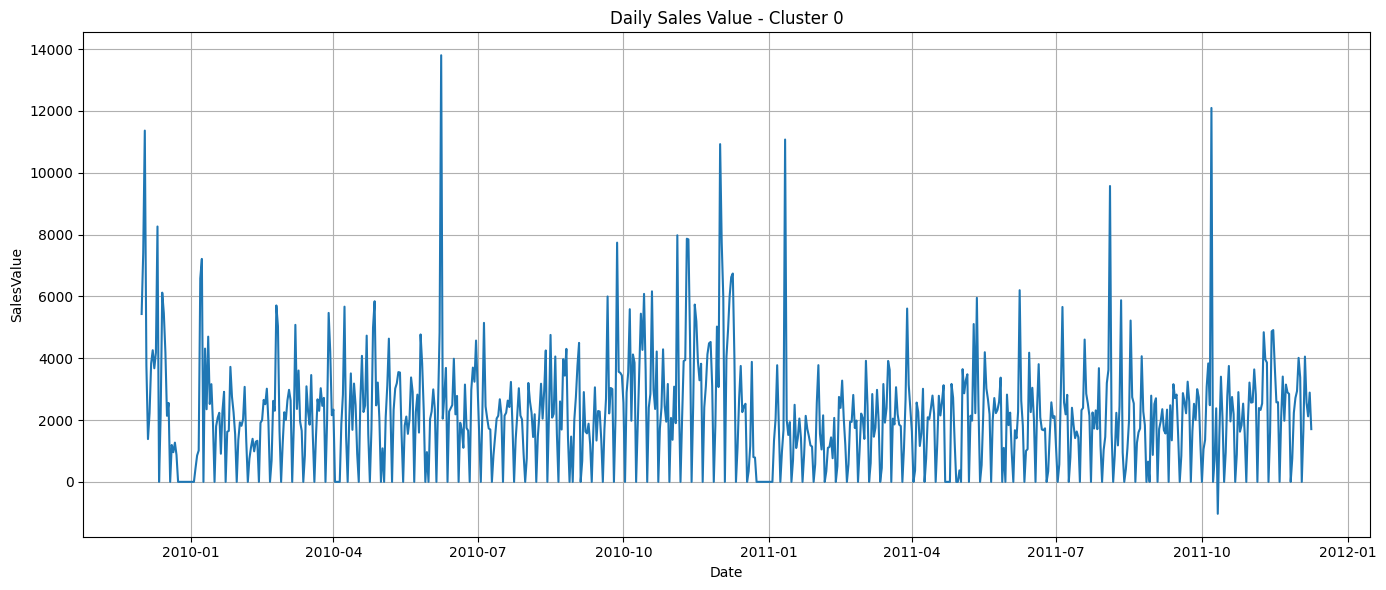

In [ ]:
# Plot daily sales value
plt.figure(figsize=(14, 6))
plt.plot(cluster0_daily.index, cluster0_daily.values)
plt.title("Daily Sales Value - Cluster 0")
plt.xlabel("Date")
plt.ylabel("SalesValue")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
high_sales = cluster0_daily[cluster0_daily > 6000]
print(high_sales)


InvoiceDate
2009-12-02     7410.48
2009-12-03    11362.15
2009-12-11     8259.88
2009-12-14     6119.63
2010-01-07     6581.37
2010-01-08     7211.46
2010-06-08    13799.28
2010-09-27     7737.44
2010-10-14     6080.24
2010-10-19     6162.63
2010-11-04     7975.54
2010-11-10     7863.96
2010-11-11     7843.14
2010-12-01    10924.22
2010-12-02     7745.32
2010-12-08     6621.00
2010-12-09     6739.34
2011-01-11    11073.06
2011-06-08     6198.96
2011-08-04     9569.53
2011-10-07    12094.34
Name: SalesValue, dtype: float64


In [ ]:
# Find dates with 0 SalesValue
zero_sales_dates = cluster0_daily[cluster0_daily == 0]

# Display the result
zero_sales_dates.head(20)


InvoiceDate
2009-12-12    0.0
2009-12-19    0.0
2009-12-24    0.0
2009-12-25    0.0
2009-12-26    0.0
2009-12-27    0.0
2009-12-28    0.0
2009-12-29    0.0
2009-12-30    0.0
2009-12-31    0.0
2010-01-01    0.0
2010-01-02    0.0
2010-01-03    0.0
2010-01-09    0.0
2010-01-16    0.0
2010-01-23    0.0
2010-01-30    0.0
2010-02-06    0.0
2010-02-13    0.0
2010-02-20    0.0
Name: SalesValue, dtype: float64

In [ ]:
# Step 1: Daily Sales
cluster0_df.index = pd.to_datetime(cluster0_df.index)
cluster0_daily = cluster0_df['SalesValue'].resample('D').sum()
cluster0_daily = cluster0_daily.asfreq('D').fillna(0)

# Step 2: Base features
data = pd.DataFrame({'SalesValue': cluster0_daily})
data['WeekdayNum'] = data.index.weekday  # 0=Mon, ..., 6=Sun

# Day-type dummy variables
data['is_weekday'] = data['WeekdayNum'].isin([0,1,2,3,4]).astype(int)
data['is_saturday'] = (data['WeekdayNum'] == 5).astype(int)
data['is_sunday'] = (data['WeekdayNum'] == 6).astype(int)

# Holiday flag (Dec 24 to Jan 3)
def is_holiday(date):
    mmdd = date.strftime('%m-%d')
    return int('12-24' <= mmdd or mmdd <= '01-03')  # Handles end/start of year

data['is_holiday'] = data.index.map(is_holiday)

# Step 3: Sliding window feature generation
X, y = [], []
window_size = 90

for i in range(window_size, len(data) - 1):
    # Sales history
    past_sales = data['SalesValue'].iloc[i - window_size:i].values

    # Dummy variables for current day
    dummies = data.iloc[i][['is_weekday', 'is_saturday', 'is_sunday', 'is_holiday']].values

    # Combine features
    features = np.concatenate([past_sales, dummies])
    X.append(features)

    # Target: next day's sales
    y.append(data['SalesValue'].iloc[i + 1])

# Step 4: Final DataFrame
columns = [f'lag_{i+1}' for i in range(window_size)] + ['is_weekday', 'is_saturday', 'is_sunday', 'is_holiday']
data_cluster0 = pd.DataFrame(X, columns=columns)
data_cluster0['target'] = y
# Fix negative target values in data_cluster0
# Drop rows where target is negative (if any)
data_cluster0 = data_cluster0[data_cluster0['target'] >= 0]
# Replace 0s in X (features), but not in y (target), or vice versa depending on goal



In [ ]:
data_cluster0

lag_1     lag_2     lag_3    lag_4    lag_5    lag_6    lag_7  \
0     5429.74   7410.48  11362.15  3767.22  1383.51  2226.69  3831.63   
1     7410.48  11362.15   3767.22  1383.51  2226.69  3831.63  4257.84   
2    11362.15   3767.22   1383.51  2226.69  3831.63  4257.84  3673.52   
3     3767.22   1383.51   2226.69  3831.63  4257.84  3673.52  4183.89   
4     1383.51   2226.69   3831.63  4257.84  3673.52  4183.89  8259.88   
..        ...       ...       ...      ...      ...      ...      ...   
643   1964.89   2350.32   1670.36  1563.83  2335.83     0.00  2476.14   
644   2350.32   1670.36   1563.83  2335.83     0.00  2476.14  1343.41   
645   1670.36   1563.83   2335.83     0.00  2476.14  1343.41  3158.92   
646   1563.83   2335.83      0.00  2476.14  1343.41  3158.92  2708.81   
647   2335.83      0.00   2476.14  1343.41  3158.92  2708.81  2824.01   

       lag_8    lag_9   lag_10  ...   lag_86   lag_87   lag_88   lag_89  \
0    4257.84  3673.52  4183.89  ...  5705.63  5036.22  1646.87     0.00   
1    3673.52  4183.89  8259.88  ...  5036.22  1646.87     0.00  1231.09   
2    4183.89  8259.88     0.00  ...  1646.87     0.00  1231.09  2251.13   
3    8259.88     0.00  2163.55  ...     0.00  1231.09  2251.13  2005.71   
4       0.00  2163.55  6119.63  ...  1231.09  2251.13  2005.71  2636.61   
..       ...      ...      ...  ...      ...      ...      ...      ...   
643  1343.41  3158.92  2708.81  ...  2714.59  2937.08  4010.44  3375.45   
644  3158.92  2708.81  2824.01  ...  2937.08  4010.44  3375.45     0.00   
645  2708.81  2824.01  1495.12  ...  4010.44  3375.45     0.00  1640.77   
646  2824.01  1495.12     0.00  ...  3375.45     0.00  1640.77  4051.85   
647  1495.12     0.00   845.40  ...     0.00  1640.77  4051.85  2568.05   

      lag_90  is_weekday  is_saturday  is_sunday  is_holiday   target  
0    1231.09         1.0          0.0        0.0         0.0  2005.71  
1    2251.13         1.0          0.0        0.0         0.0  2636.61  
2    2005.71         1.0          0.0        0.0         0.0  2976.37  
3    2636.61         1.0          0.0        0.0         0.0  2631.88  
4    2976.37         1.0          0.0        0.0         0.0     0.00  
..       ...         ...          ...        ...         ...      ...  
643     0.00         0.0          0.0        1.0         0.0  4051.85  
644  1640.77         1.0          0.0        0.0         0.0  2568.05  
645  4051.85         1.0          0.0        0.0         0.0  2119.65  
646  2568.05         1.0          0.0        0.0         0.0  2887.02  
647  2119.65         1.0          0.0        0.0         0.0  1705.32  

[647 rows x 95 columns]

In [ ]:
# Define SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])

# Step 1: Split into train/test (80/20)
X = data_cluster0.drop(columns=['target'])
y = data_cluster0['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # time series split, no shuffle
)

# Step 2: Grid search setup
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

# Adjusted values for MAPE
y_test_adj = np.where(y_test == 0, 1, y_test)
y_pred_adj = np.where(y_pred == 0, 1, y_pred)

# Compute MAPE and SMAPE
mape = mean_absolute_percentage_error(y_test_adj, y_pred_adj)
smape_score = smape(y_test, y_pred)

# Print results
print(f"Adjusted MAPE (0s replaced with 1): {mape:.4f}")
print(f"SMAPE: {smape_score:.4f}")
print("Best Parameters:", grid.best_params_)


Adjusted MAPE (0s replaced with 1): 16.9086
SMAPE: 0.3670
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


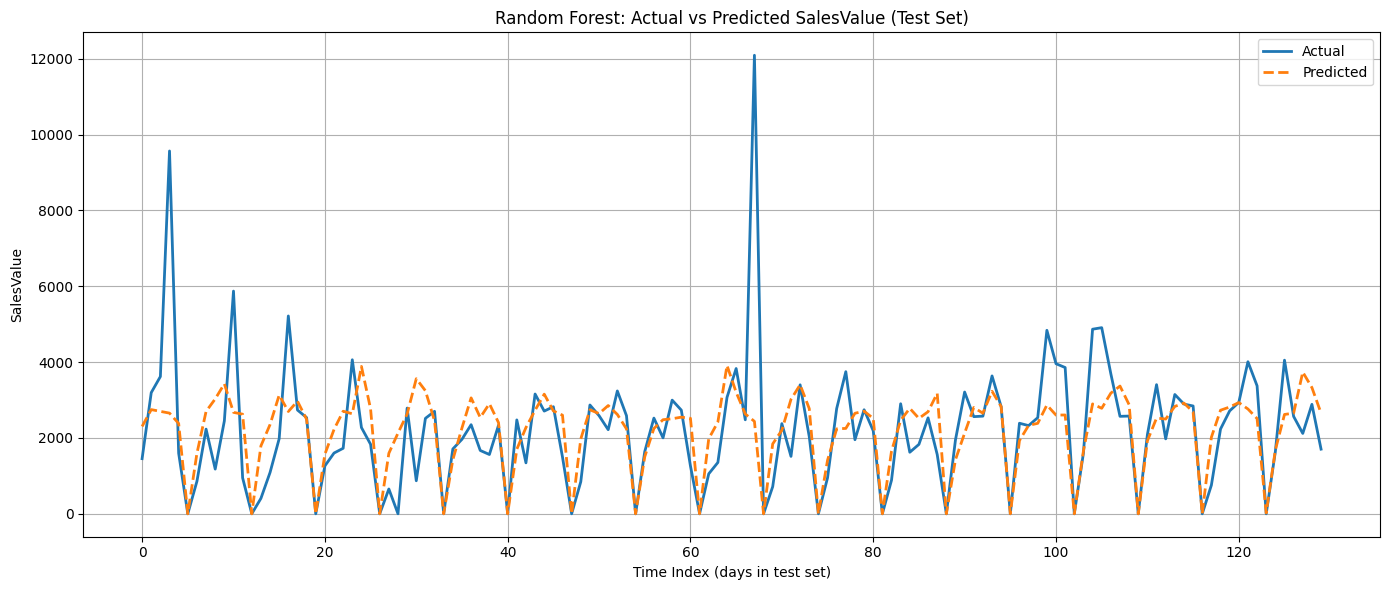

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2, linestyle='--')

plt.title("Random Forest: Actual vs Predicted SalesValue (Test Set)")
plt.xlabel("Time Index (days in test set)")
plt.ylabel("SalesValue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
cluster1_df

Invoice StockCode                       Description  \
InvoiceDate                                                               
2009-12-01 07:45:00  489434     22041      RECORD FRAME 7" SINGLE SIZE    
2009-12-01 07:45:00  489434     21871               SAVE THE PLANET MUG   
2009-12-01 09:06:00  489436     21755          LOVE BUILDING BLOCK WORD   
2009-12-01 09:06:00  489436     21754          HOME BUILDING BLOCK WORD   
2009-12-01 09:06:00  489436     22109      FULL ENGLISH BREAKFAST PLATE   
...                     ...       ...                               ...   
2011-12-09 12:25:00  581584     85038   6 CHOCOLATE LOVE HEART T-LIGHTS   
2011-12-09 12:31:00  581585     22178   VICTORIAN GLASS HANGING T-LIGHT   
2011-12-09 12:31:00  581585     16016       LARGE CHINESE STYLE SCISSOR   
2011-12-09 12:31:00  581585     21684  SMALL MEDINA STAMPED METAL BOWL    
2011-12-09 12:50:00  581587     22138     BAKING SET 9 PIECE RETROSPOT    

                     Quantity  Price  Customer ID         Country YearMonth  \
InvoiceDate                                                                   
2009-12-01 07:45:00        48   2.10      13085.0  United Kingdom   2009-12   
2009-12-01 07:45:00        24   1.25      13085.0  United Kingdom   2009-12   
2009-12-01 09:06:00        18   5.45      13078.0  United Kingdom   2009-12   
2009-12-01 09:06:00         3   5.95      13078.0  United Kingdom   2009-12   
2009-12-01 09:06:00        16   3.39      13078.0  United Kingdom   2009-12   
...                       ...    ...          ...             ...       ...   
2011-12-09 12:25:00        48   1.85      13777.0  United Kingdom   2011-12   
2011-12-09 12:31:00        12   1.95      15804.0  United Kingdom   2011-12   
2011-12-09 12:31:00        10   0.85      15804.0  United Kingdom   2011-12   
2011-12-09 12:31:00        12   0.85      15804.0  United Kingdom   2011-12   
2011-12-09 12:50:00         3   4.95      12680.0          France   2011-12   

                    SP500_Close   CPI  data_based_cluster  desc_based_cluster  \
InvoiceDate                                                                     
2009-12-01 07:45:00    1,115.10  2.51                   3                   1   
2009-12-01 07:45:00    1,115.10  2.51                   8                   2   
2009-12-01 09:06:00    1,115.10  2.51                   8                  11   
2009-12-01 09:06:00    1,115.10  2.51                   8                  11   
2009-12-01 09:06:00    1,115.10  2.51                   2                   2   
...                         ...   ...                 ...                 ...   
2011-12-09 12:25:00    1,257.60  3.69                   2                   3   
2011-12-09 12:31:00    1,257.60  3.69                   3                   3   
2011-12-09 12:31:00    1,257.60  3.69                   7                   4   
2011-12-09 12:31:00    1,257.60  3.69                   7                   1   
2011-12-09 12:50:00    1,257.60  3.69                   3                   5   

                     word2vec_cluster  SalesValue  
InvoiceDate                                        
2009-12-01 07:45:00                 1      100.80  
2009-12-01 07:45:00                 1       30.00  
2009-12-01 09:06:00                 1       98.10  
2009-12-01 09:06:00                 1       17.85  
2009-12-01 09:06:00                 1       54.24  
...                               ...         ...  
2011-12-09 12:25:00                 1       88.80  
2011-12-09 12:31:00                 1       23.40  
2011-12-09 12:31:00                 1        8.50  
2011-12-09 12:31:00                 1       10.20  
2011-12-09 12:50:00                 1       14.85  

[143357 rows x 14 columns]

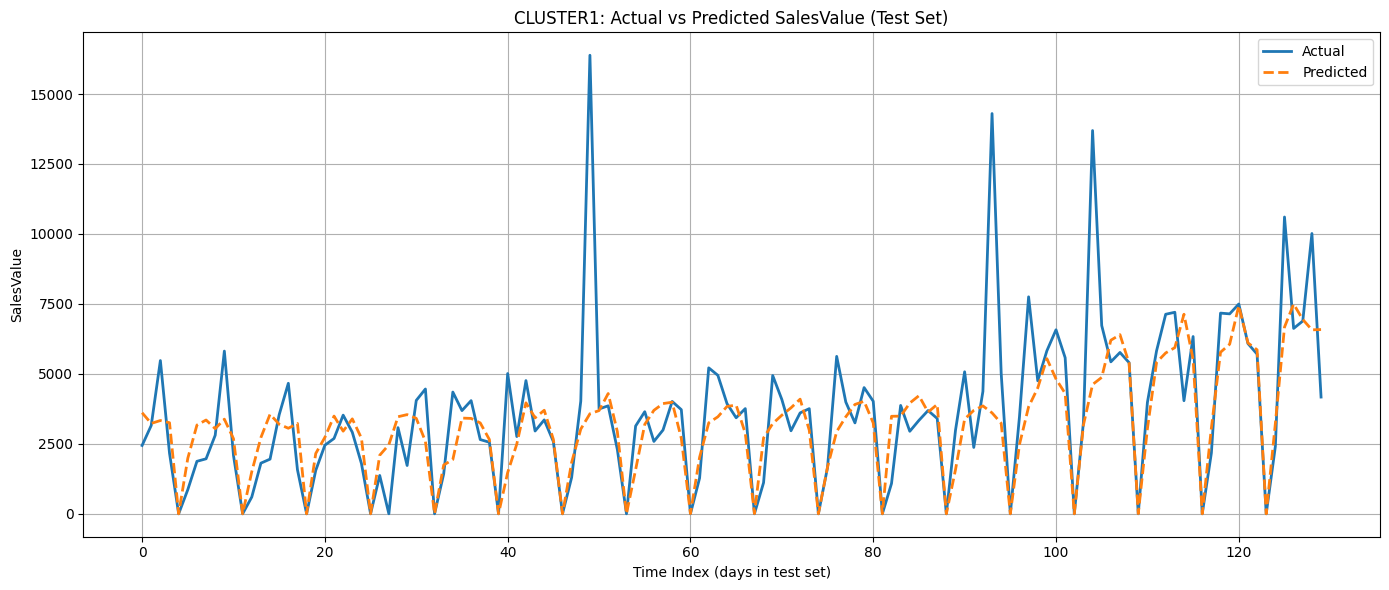

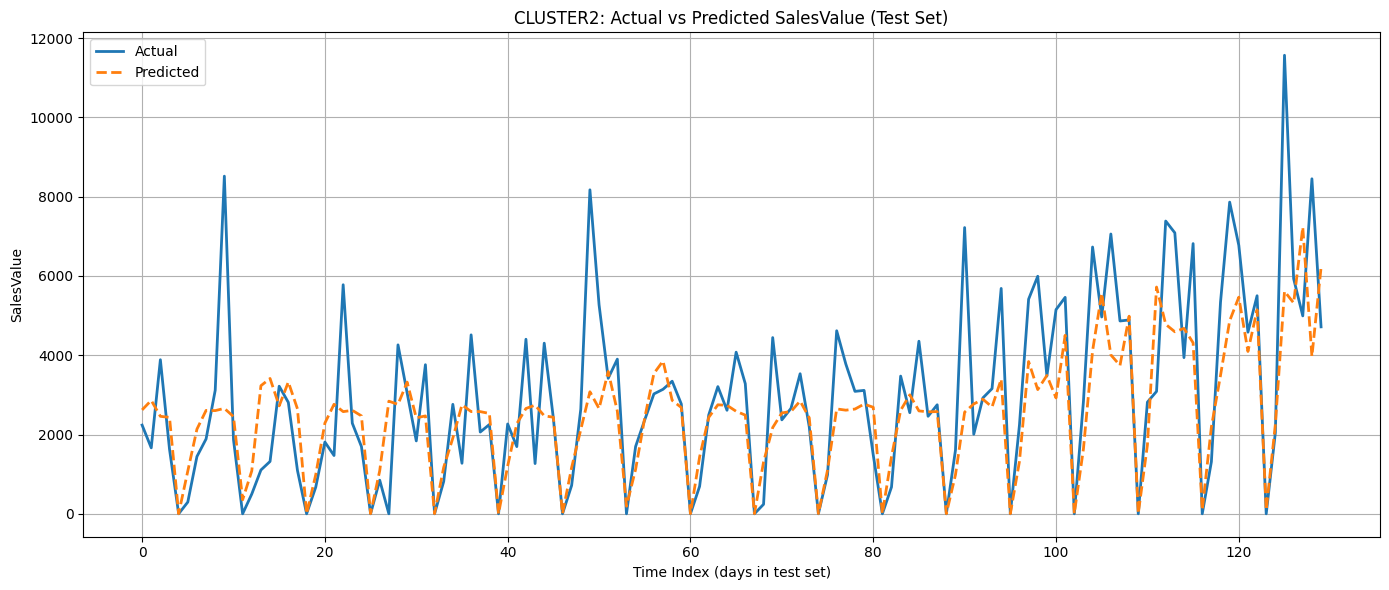

({'cluster': 'cluster1',
  'best_params': {'max_depth': None,
   'min_samples_split': 2,
   'n_estimators': 100},
  'smape': np.float64(0.37158726063228853)},
 {'cluster': 'cluster2',
  'best_params': {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100},
  'smape': np.float64(0.6176279258011748)})

In [ ]:
# SMAPE definition
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])

# Main cluster function
def process_cluster(cluster_df, cluster_name="cluster"):
    cluster_df.index = pd.to_datetime(cluster_df.index)
    daily_sales = cluster_df['SalesValue'].resample('D').sum().asfreq('D').fillna(0)

    data = pd.DataFrame({'SalesValue': daily_sales})
    data['WeekdayNum'] = data.index.weekday
    data['is_weekday'] = data['WeekdayNum'].isin([0,1,2,3,4]).astype(int)
    data['is_saturday'] = (data['WeekdayNum'] == 5).astype(int)
    data['is_sunday'] = (data['WeekdayNum'] == 6).astype(int)

    def is_holiday(date):
        mmdd = date.strftime('%m-%d')
        return int('12-24' <= mmdd or mmdd <= '01-03')

    data['is_holiday'] = data.index.map(is_holiday)

    X, y = [], []
    window_size = 90
    for i in range(window_size, len(data) - 1):
        past_sales = data['SalesValue'].iloc[i - window_size:i].values
        dummies = data.iloc[i][['is_weekday', 'is_saturday', 'is_sunday', 'is_holiday']].values
        features = np.concatenate([past_sales, dummies])
        X.append(features)
        y.append(data['SalesValue'].iloc[i + 1])

    columns = [f'lag_{i+1}' for i in range(window_size)] + ['is_weekday', 'is_saturday', 'is_sunday', 'is_holiday']
    data_cluster = pd.DataFrame(X, columns=columns)
    data_cluster['target'] = y
    data_cluster = data_cluster[data_cluster['target'] >= 0]

    X = data_cluster.drop(columns=['target'])
    y = data_cluster['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }

    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_rf = grid.best_estimator_
    y_pred = best_rf.predict(X_test)

    # SMAPE calculation
    smape_score = smape(y_test.values, y_pred)

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(y_test.values, label='Actual', linewidth=2)
    plt.plot(y_pred, label='Predicted', linewidth=2, linestyle='--')
    plt.title(f"{cluster_name.upper()}: Actual vs Predicted SalesValue (Test Set)")
    plt.xlabel("Time Index (days in test set)")
    plt.ylabel("SalesValue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "cluster": cluster_name,
        "best_params": grid.best_params_,
        "smape": smape_score
    }

# Process both clusters
result1 = process_cluster(cluster1_df, "cluster1")
result2 = process_cluster(cluster2_df, "cluster2")

result1, result2


LSTM

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 48.8463
Epoch 2/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.4342
Epoch 3/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.6721
Epoch 4/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.1126
Epoch 5/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9378
Epoch 6/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4613
Epoch 7/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8278
Epoch 8/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0366
Epoch 9/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7036
Epoch 10/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0338
Epoch 11/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2972
Epoch 12/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0678
Epoch 13/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9683
Epoch 14/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6677
Epoch 15/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7554
Epoch 16/80
17/17 ━━━━━━━━

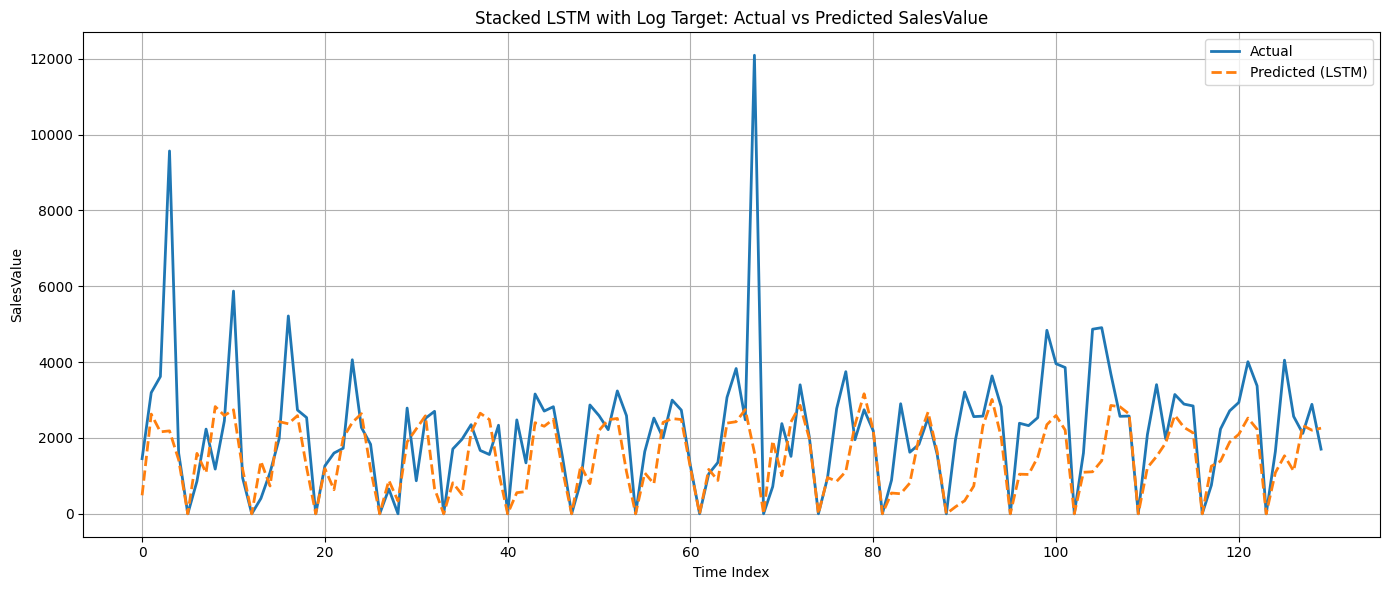

In [ ]:
# Define SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])

# --- Step 1: Prepare Data ---
X_raw = data_cluster0.drop(columns=['target']).values
y_raw = data_cluster0['target'].values

# Scale features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Log transform target
y_log = np.log1p(y_raw)

# Split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, y_log, test_size=0.2, shuffle=False
)

# --- Step 2: Build Stacked LSTM Model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train_log,
    epochs=80, batch_size=32, verbose=1
)

# --- Step 3: Predict and Inverse Log Transform ---
y_pred_log = model.predict(X_test).flatten()
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# --- Step 4: Compute SMAPE ---
smape_score = smape(y_test, y_pred)
print(f"SMAPE: {smape_score:.4f}")

# --- Step 5: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted (LSTM)', linewidth=2, linestyle='--')
plt.title("Stacked LSTM with Log Target: Actual vs Predicted SalesValue")
plt.xlabel("Time Index")
plt.ylabel("SalesValue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- Define SMAPE ---
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])

# --- Data prep ---
X_raw = data_cluster0.drop(columns=['target']).values
y_raw = data_cluster0['target'].values

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_log = np.log1p(y_raw)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, shuffle=False)

# --- Grid settings ---
param_grid = [
    {'units1': 64, 'units2': 32, 'dropout': 0.3, 'batch_size': 32, 'epochs': 60},
    {'units1': 128, 'units2': 64, 'dropout': 0.3, 'batch_size': 32, 'epochs': 60},
    {'units1': 64, 'units2': 32, 'dropout': 0.5, 'batch_size': 32, 'epochs': 60},
    {'units1': 128, 'units2': 64, 'dropout': 0.5, 'batch_size': 32, 'epochs': 60}
]

best_smape = float('inf')
best_params = None

for params in param_grid:
    model = Sequential([
        LSTM(params['units1'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(params['dropout']),
        LSTM(params['units2']),
        Dropout(params['dropout']),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

    y_pred_log = model.predict(X_test).flatten()
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    smape_score = smape(y_true, y_pred)
    print(f"Params: {params}, SMAPE: {smape_score:.4f}")

    if smape_score < best_smape:
        best_smape = smape_score
        best_params = params

print("Best Params:", best_params)
print("Best SMAPE:", best_smape)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Params: {'units1': 64, 'units2': 32, 'dropout': 0.3, 'batch_size': 32, 'epochs': 60}, SMAPE: 0.6912
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Params: {'units1': 128, 'units2': 64, 'dropout': 0.3, 'batch_size': 32, 'epochs': 60}, SMAPE: 0.7262
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Params: {'units1': 64, 'units2': 32, 'dropout': 0.5, 'batch_size': 32, 'epochs': 60}, SMAPE: 0.7011
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Params: {'units1': 128, 'units2': 64, 'dropout': 0.5, 'batch_size': 32, 'epochs': 60}, SMAPE: 0.7009
Best Params: {'units1': 64, 'units2': 32, 'dropout': 0.3, 'batch_size': 32, 'epochs': 60}
Best SMAPE: 0.6912012348887484


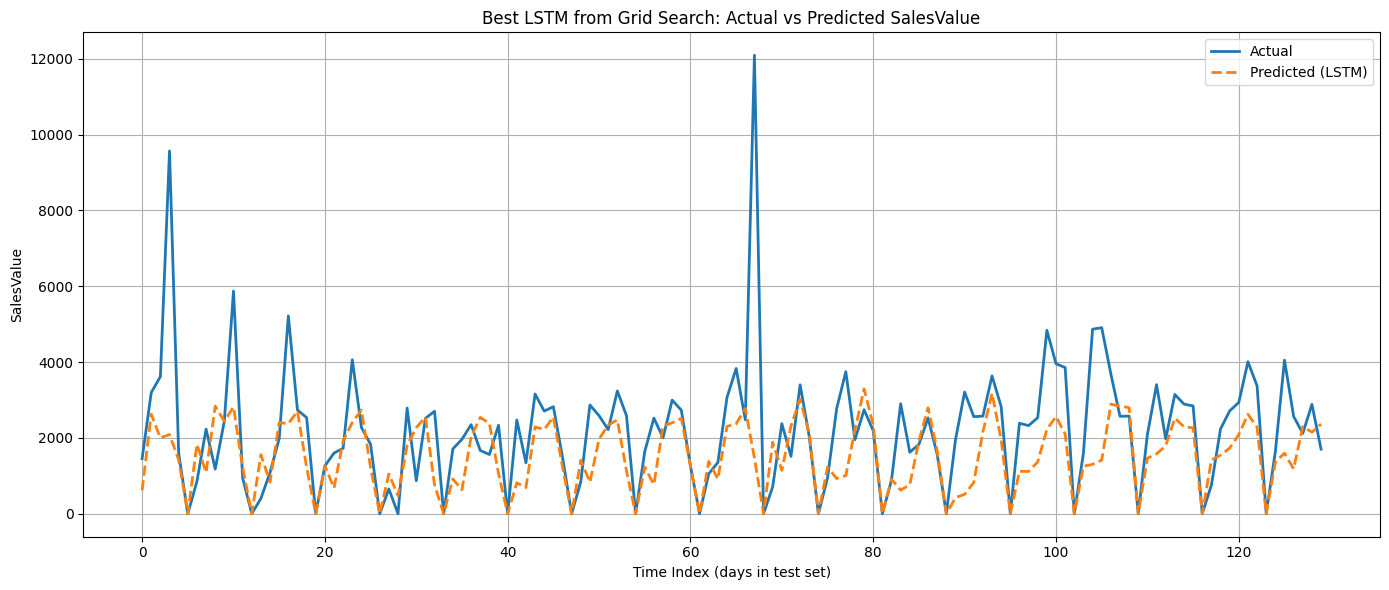

In [ ]:
# Convert log values back to original scale
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_actual, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted (LSTM)', linewidth=2, linestyle='--')

plt.title("Best LSTM from Grid Search: Actual vs Predicted SalesValue")
plt.xlabel("Time Index (days in test set)")
plt.ylabel("SalesValue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


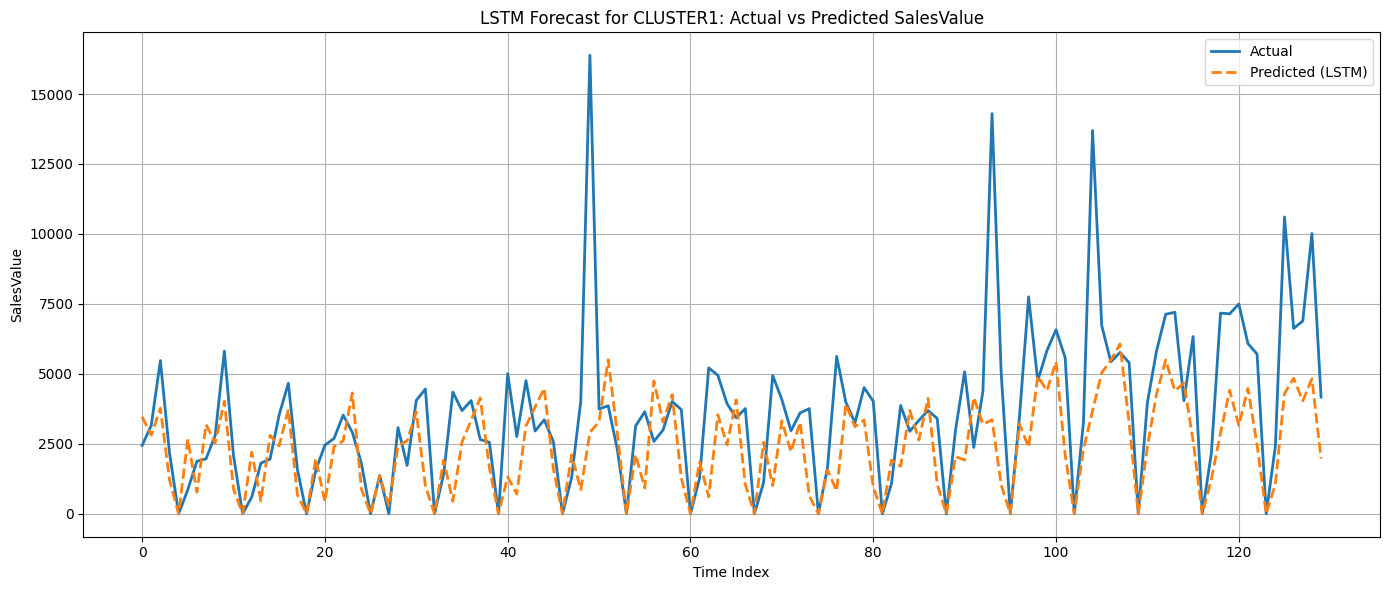

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


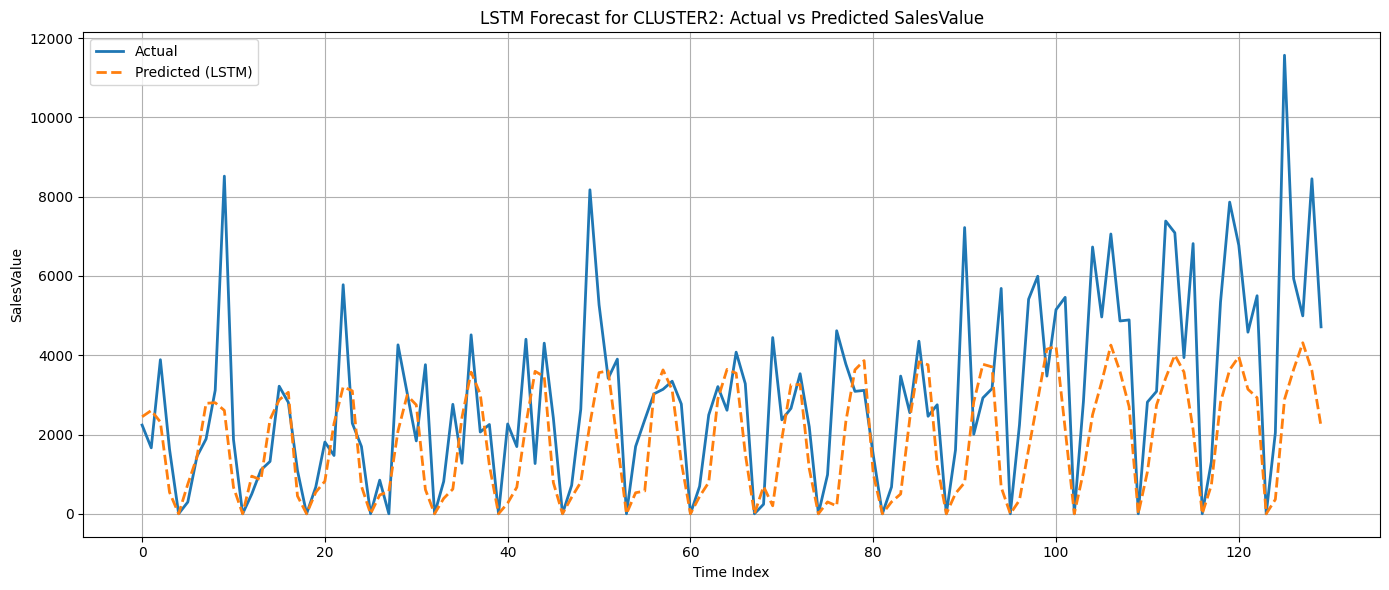

(np.float64(0.7734925911289049), np.float64(0.8272795374727253))

In [ ]:
# --- Define SMAPE ---
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])

# --- Main LSTM Forecasting Function ---
def process_lstm_cluster(cluster_df, name):
    cluster_df.index = pd.to_datetime(cluster_df.index)
    daily_sales = cluster_df['SalesValue'].resample('D').sum().asfreq('D').fillna(0)

    data = pd.DataFrame({'SalesValue': daily_sales})
    data['WeekdayNum'] = data.index.weekday
    data['is_weekday'] = data['WeekdayNum'].isin([0, 1, 2, 3, 4]).astype(int)
    data['is_saturday'] = (data['WeekdayNum'] == 5).astype(int)
    data['is_sunday'] = (data['WeekdayNum'] == 6).astype(int)

    def is_holiday(date):
        mmdd = date.strftime('%m-%d')
        return int('12-24' <= mmdd or mmdd <= '01-03')

    data['is_holiday'] = data.index.map(is_holiday)

    X, y = [], []
    window_size = 90
    for i in range(window_size, len(data) - 1):
        past_sales = data['SalesValue'].iloc[i - window_size:i].values
        dummies = data.iloc[i][['is_weekday', 'is_saturday', 'is_sunday', 'is_holiday']].values
        features = np.concatenate([past_sales, dummies])
        X.append(features)
        y.append(data['SalesValue'].iloc[i + 1])

    columns = [f'lag_{i+1}' for i in range(window_size)] + ['is_weekday', 'is_saturday', 'is_sunday', 'is_holiday']
    df_cluster = pd.DataFrame(X, columns=columns)
    df_cluster['target'] = y
    df_cluster = df_cluster[df_cluster['target'] >= 0]

    X_raw = df_cluster.drop(columns=['target']).values
    y_raw = df_cluster['target'].values

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw).reshape((X_raw.shape[0], 1, X_raw.shape[1]))
    y_log = np.log1p(y_raw)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, shuffle=False)

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=0)

    y_pred_log = model.predict(X_test).flatten()
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    smape_score = smape(y_true, y_pred)

    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label='Actual', linewidth=2)
    plt.plot(y_pred, label='Predicted (LSTM)', linewidth=2, linestyle='--')
    plt.title(f"LSTM Forecast for {name.upper()}: Actual vs Predicted SalesValue")
    plt.xlabel("Time Index")
    plt.ylabel("SalesValue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return smape_score

# Run for cluster1 and cluster2
smape1 = process_lstm_cluster(cluster1_df, "cluster1")
smape2 = process_lstm_cluster(cluster2_df, "cluster2")

smape1, smape2


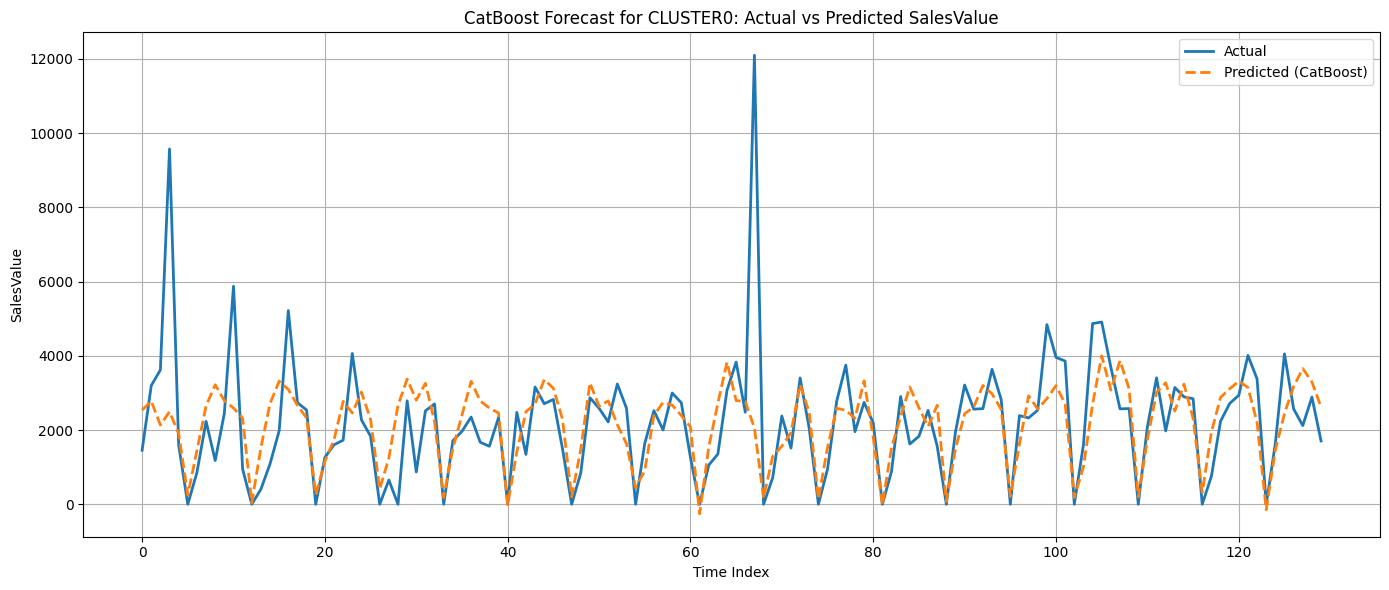

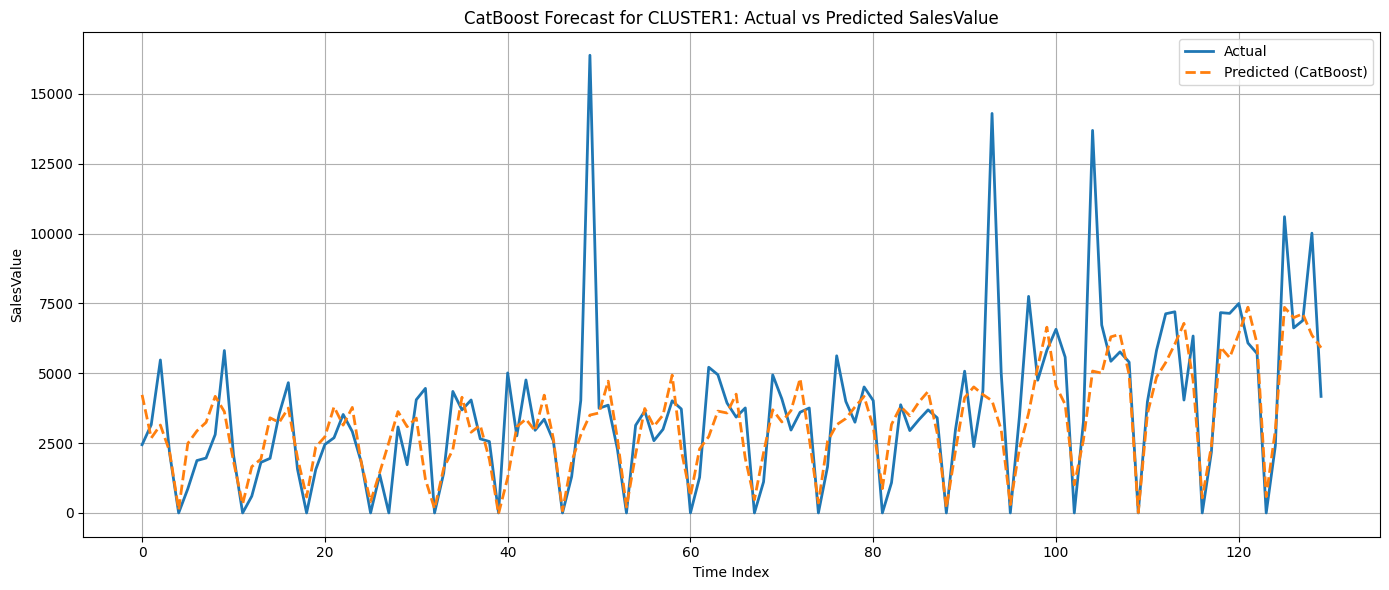

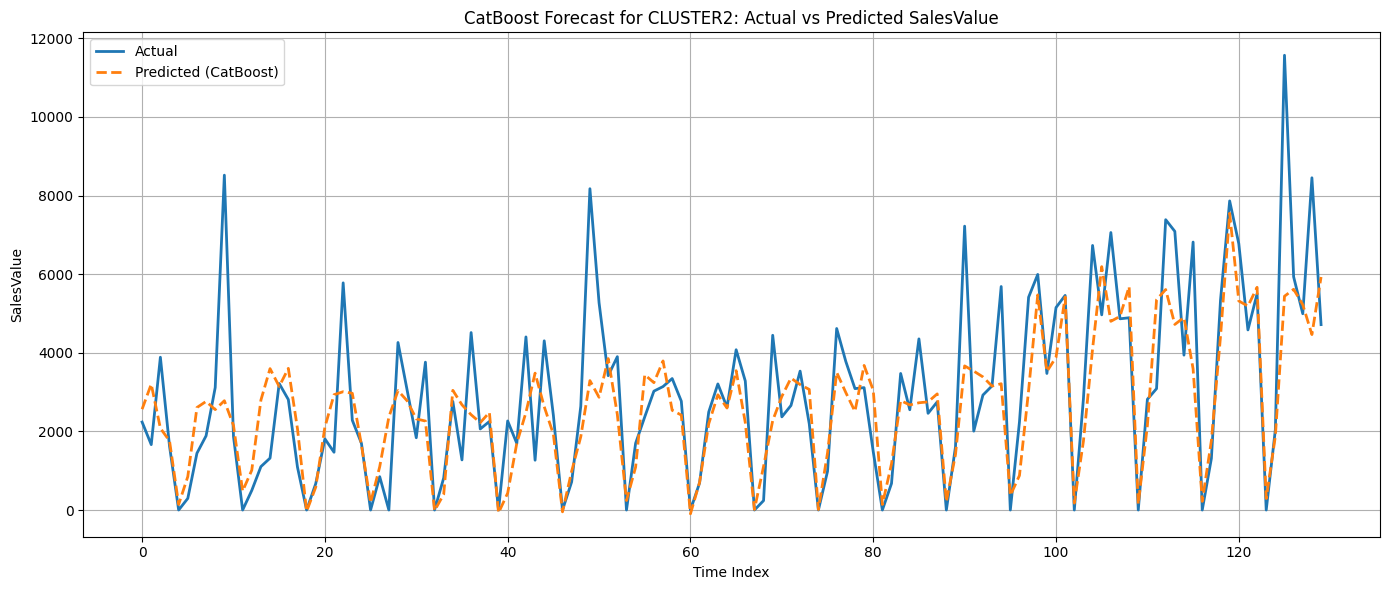

(np.float64(0.590703106864706),
 np.float64(0.5641630087906736),
 np.float64(0.5915375734953346))

In [ ]:
# Define SMAPE function
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])

# Reusable function for CatBoost processing
def process_catboost_cluster(cluster_df, name):
    cluster_df.index = pd.to_datetime(cluster_df.index)
    daily_sales = cluster_df['SalesValue'].resample('D').sum().asfreq('D').fillna(0)

    # Feature engineering
    data = pd.DataFrame({'SalesValue': daily_sales})
    data['WeekdayNum'] = data.index.weekday
    data['is_weekday'] = data['WeekdayNum'].isin([0,1,2,3,4]).astype(int)
    data['is_saturday'] = (data['WeekdayNum'] == 5).astype(int)
    data['is_sunday'] = (data['WeekdayNum'] == 6).astype(int)

    def is_holiday(date):
        mmdd = date.strftime('%m-%d')
        return int('12-24' <= mmdd or mmdd <= '01-03')

    data['is_holiday'] = data.index.map(is_holiday)

    # Sliding window
    X, y = [], []
    window_size = 90
    for i in range(window_size, len(data) - 1):
        past_sales = data['SalesValue'].iloc[i - window_size:i].values
        dummies = data.iloc[i][['is_weekday', 'is_saturday', 'is_sunday', 'is_holiday']].values
        features = np.concatenate([past_sales, dummies])
        X.append(features)
        y.append(data['SalesValue'].iloc[i + 1])

    X = np.array(X)
    y = np.array(y)
    X = X[y >= 0]
    y = y[y >= 0]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train CatBoost model
    model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0, random_seed=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    smape_score = smape(y_test, y_pred)

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(y_test, label='Actual', linewidth=2)
    plt.plot(y_pred, label='Predicted (CatBoost)', linewidth=2, linestyle='--')
    plt.title(f"CatBoost Forecast for {name.upper()}: Actual vs Predicted SalesValue")
    plt.xlabel("Time Index")
    plt.ylabel("SalesValue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return smape_score

# Run for all clusters
smape_cb_0 = process_catboost_cluster(cluster0_df, "cluster0")
smape_cb_1 = process_catboost_cluster(cluster1_df, "cluster1")
smape_cb_2 = process_catboost_cluster(cluster2_df, "cluster2")

smape_cb_0, smape_cb_1, smape_cb_2
